In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import pandas as pd

In [30]:
def MEG_gradient(X, time, N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_overall_conc, Pase_grad, PLK1_overall_conc, PLK1_grad):
    
    x=2*PLK1_overall_conc/(2-PLK1_grad)
    PLK_conc = np.linspace((1-PLK1_grad)*x, x, N)
    
    x=2*Pase_overall_conc/(2-Pase_grad)
    Pase_conc = np.linspace(x,(1-Pase_grad)*x, N)
    
    dx=np.zeros(4*N)
    
    # equations for M - dx[0 to N-1] is M conc in cpts 0 to N-1
    for i in range(N):
        
        if i==0:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+Df*(X[i+1]-X[i])
        
        elif i==N-1:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+Df*(X[i-1]-X[i])
            
        else:
            dx[i]=kcat1_km1*Pase_conc[i]*X[i+N]-kcat2_km2*PLK_conc[i]*X[i]-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+Df*(X[i+1]+X[i-1]-2*X[i]) 
    
    # equations for MP - dx[N to 2N-1] is M conc in cpts 0 to N-1
    
    for i in range(N):
        
        if i==0:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]+Df*(X[i+N+1]-X[i+N])
        
        elif i==N-1:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]+Df*(X[i+N-1]-X[i+N])
            
        else:
            dx[i+N]=-kcat1_km1*Pase_conc[i]*X[i+N]+kcat2_km2*PLK_conc[i]*X[i]+kcat2_km2*PLK_conc[i]*X[i+3*N]+Df*(X[i+N+1]+X[i+N-1]-2*X[i+N]) 
    
    # equations for R - dx[2*N to 3N-1] is R conc in cpts 0 to N-1
    
    for i in range(N):
        
        dx[i+2*N]=-k1*X[i]*X[i+2*N]+k2*X[i+3*N]+kcat2_km2*PLK_conc[i]*X[i+3*N]
        
    
    # equations for MR - dx[3*N to 4N-1] is MR conc in cpts 0 to N-1
    
    for i in range(N):
        
        if i==0:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]+Ds*(X[i+3*N+1]-X[i+3*N])
        
        elif i==N-1:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]+Ds*(X[i+3*N-1]-X[i+3*N])
            
        else:
            dx[i+3*N]=k1*X[i]*X[i+2*N]-k2*X[i+3*N]-kcat2_km2*PLK_conc[i]*X[i+3*N]+Ds*(X[i+3*N+1]+X[i+3*N-1]-2*X[i+3*N]) 
    
    return dx

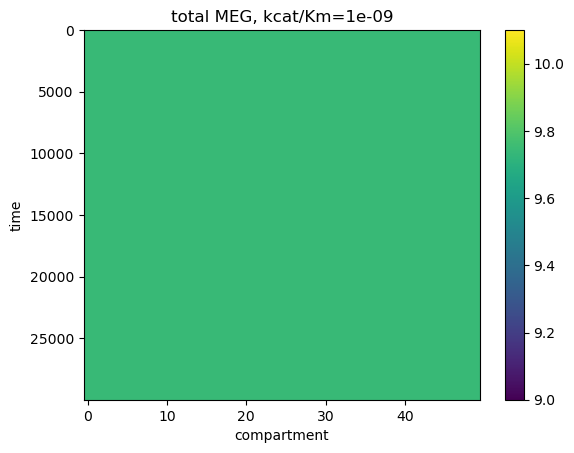

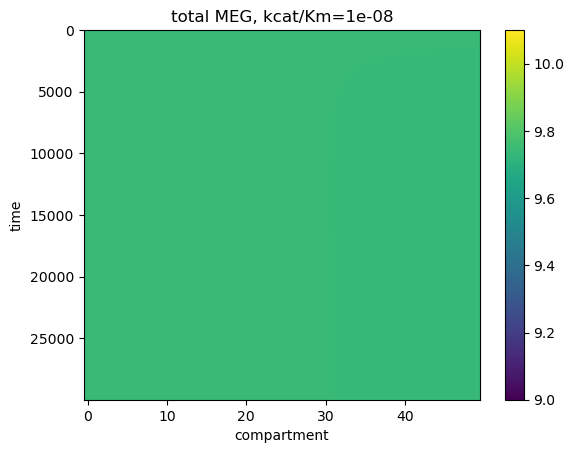

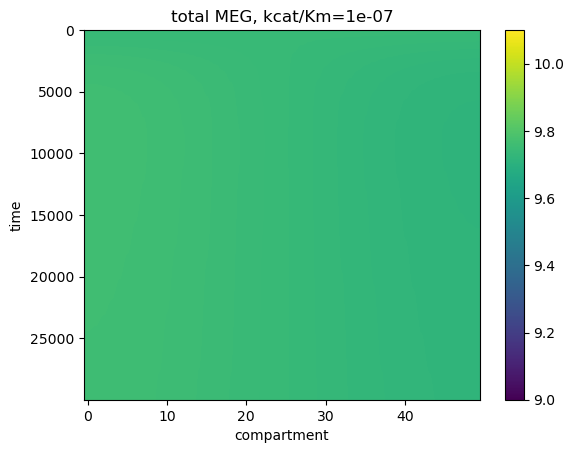

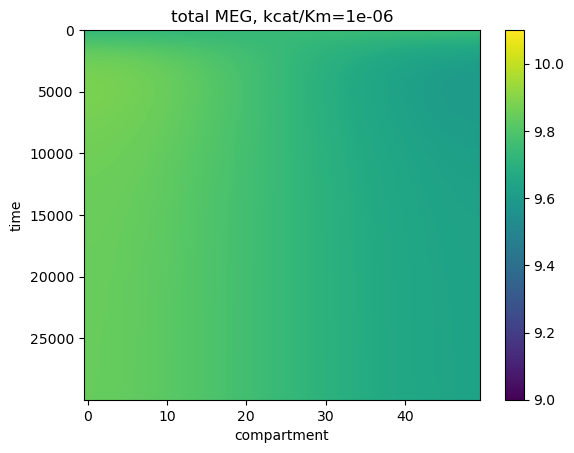

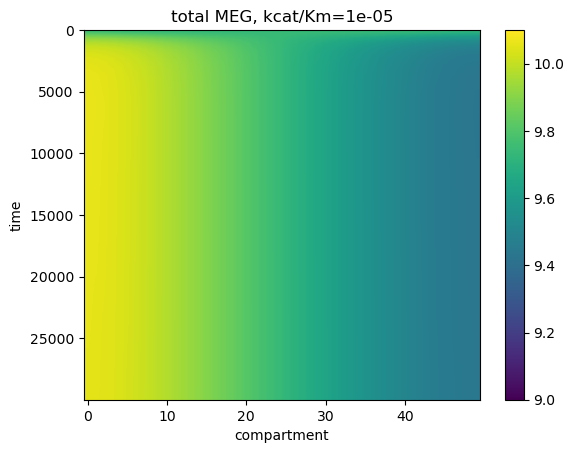

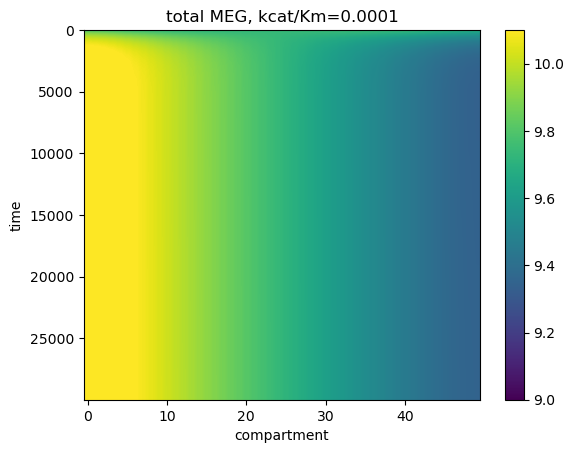

In [31]:
# Phosphatase equal conc. and kcat/Km to PLK-1 and uniformly distributed
# varying kcat/km from literature

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

    
k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0.25

gradient_strength = []
kcat_km_values = [10**(-9), 10**(-8), 10**(-7), 10**(-6), 10**(-5), 10**(-4)]

for count, kcat_km in enumerate(kcat_km_values):
    
    params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params) 
    
    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    gradient_strength.append(1-anterior_MEG/posterior_MEG)
    
    total_MEG = sol[:, range(N)]+sol[:,range(N,2*N)]+sol[:,range(3*N,4*N)]    
    cs = plt.imshow(total_MEG, aspect='auto', vmin=9.0, vmax=10.1)
    plt.title(f'total MEG, kcat/Km={kcat_km}')
    plt.xlabel('compartment')
    plt.ylabel('time')
    plt.colorbar(cs)
    plt.show()

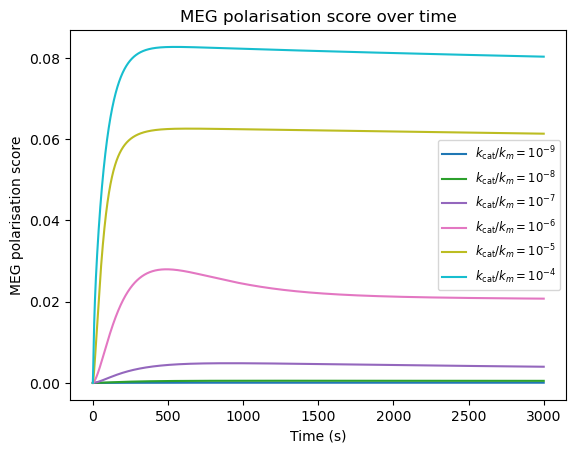

In [32]:
def format_scientific_notation(num):
    """
    Manually formats a number into '10^{exponent}' notation.
    """
    if num == 0:
        return "10^{0}"
    exponent = int(np.floor(np.log10(abs(num))))
    return r'10^{{{}}}'.format(exponent)

color = plt.cm.tab10(np.linspace(0, 1, len(kcat_km_values)))

for i, color_val in zip(range(len(kcat_km_values)), color):
    formatted_value = format_scientific_notation(kcat_km_values[i])
    label = r'$k_{\text{cat}}/k_m=' + formatted_value + r'$'
    plt.plot(t, gradient_strength[i], label=label, color=color_val)

plt.legend(loc='best', fontsize='small')
plt.xlabel('Time (s)')
plt.ylabel('MEG polarisation score')
plt.title("MEG polarisation score over time")

plt.savefig("MEG_pol_score_over_time.pdf")
plt.show()
plt.close()

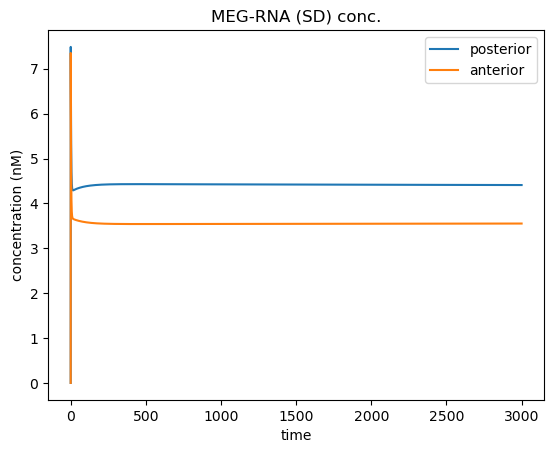

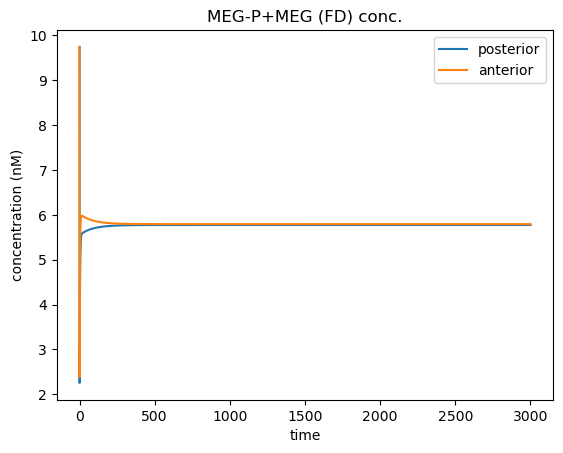

[    0.  6000. 12000. 18000. 24000. 30000.]


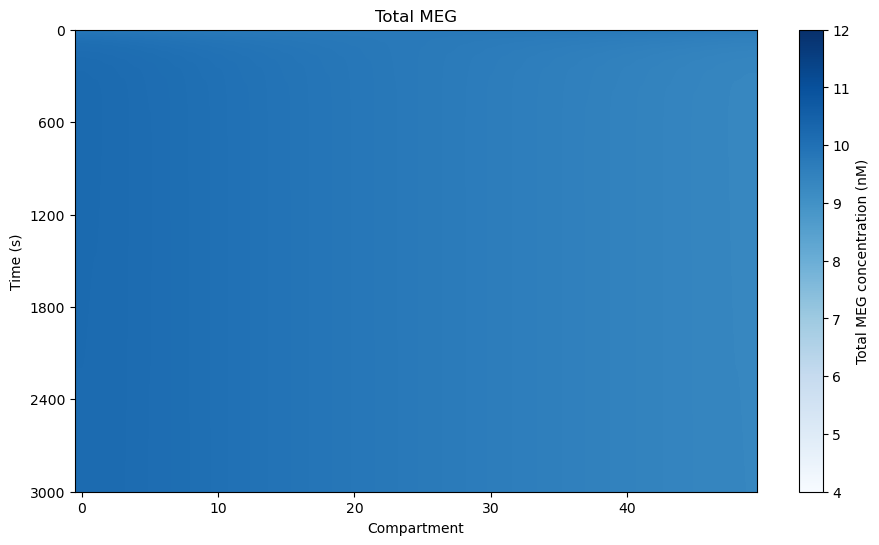

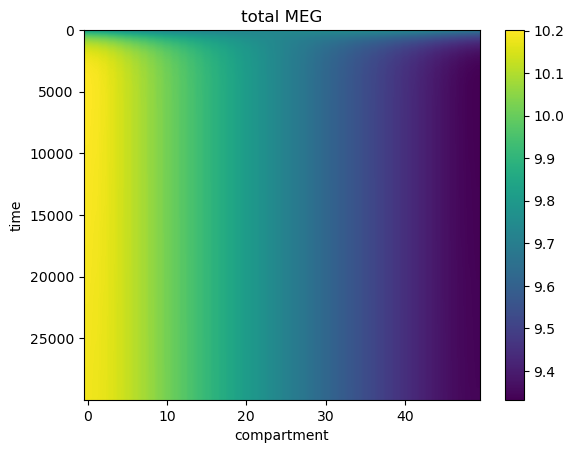

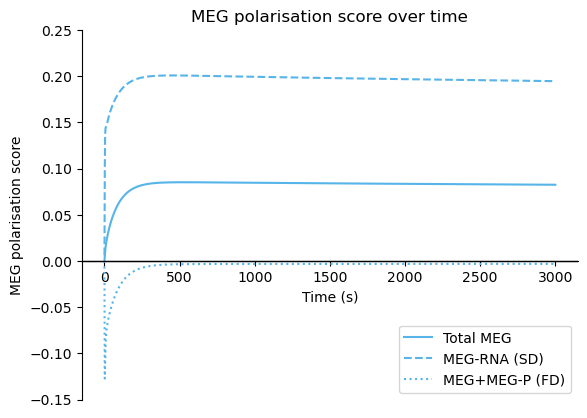

In [35]:
# taking kcat/km=1.8*10^(-4) (highest value for PLK-1 from literature)

kcat_km=1.8*10**(-4)
params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
sol=odeint(MEG_gradient, init, t, params) 

plt.plot(t, sol[:, 3*N], label="posterior")
plt.plot(t, sol[:, 4*N-1], label="anterior")
plt.title('MEG-RNA (SD) conc.')
plt.xlabel('time')
plt.ylabel('concentration (nM)')
plt.legend()
plt.show()

plt.plot(t, sol[:,0]+sol[:, N], label="posterior")
plt.plot(t, sol[:,N-1]+sol[:, 2*N-1], label="anterior")
plt.title('MEG-P+MEG (FD) conc.')
plt.xlabel('time')
plt.ylabel('concentration (nM)')
plt.legend()
plt.show()  

total_MEG = sol[:, range(N)]+sol[:,range(N,2*N)]+sol[:,range(3*N,4*N)]
fig, ax = plt.subplots(figsize=(11, 6)) 
cs = ax.imshow(total_MEG, aspect='auto', cmap='Blues', vmin=4, vmax=12)
ax.set_title('Total MEG')
ax.set_xlabel('Compartment')
# Generating new y-axis labels by dividing existing labels by 10

y_ticks = np.linspace(0, total_MEG.shape[0], num=6)
#y_ticks = np.arange(0, total_MEG.shape[0], total_MEG.shape[0] / len(ax.get_yticks()))
print(y_ticks)
ax.set_yticks(y_ticks)
#ax.set_yticklabels([f"{tick/10:.0f}" for tick in y_ticks])
ax.set_yticklabels([f"{int(y*3000/(total_MEG.shape[0]))}" for y in y_ticks])

ax.set_ylabel('Time (s)')
cbar = fig.colorbar(cs)
cbar.set_label('Total MEG concentration (nM)')

plt.savefig('Total_MEG_heat_map.pdf')
plt.show()

#plt.savefig('Total_MEG_heat_map.pdf')
#plt.show()

total_MEG = sol[:, range(N)]+sol[:,range(N,2*N)]+sol[:,range(3*N,4*N)]
cs = plt.imshow(total_MEG, aspect='auto')
plt.title('total MEG')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
MEG_gradient_strength=1-anterior_MEG/posterior_MEG

posterior_SD = sol[1:, 3*N]
anterior_SD = sol[1:, 4*N-1]
SD_gradient_strength=1-anterior_SD/posterior_SD

posterior_FD = sol[:, 0]+sol[:, N]
anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
FD_gradient_strength=1-anterior_FD/posterior_FD

plt.plot(t, MEG_gradient_strength, label="Total MEG", color="#56B4E9")  # Regular line by default
plt.plot(t[1:], SD_gradient_strength, label="MEG-RNA (SD)", color="#56B4E9", linestyle='--')  # Dashed line
plt.plot(t, FD_gradient_strength, label="MEG+MEG-P (FD)", color="#56B4E9", linestyle=':')  # Dotted line
plt.legend(loc='best')
plt.title("MEG polarisation score over time")
plt.xlabel('Time (s)')
plt.ylabel('MEG polarisation score')


plt.ylim(-0.15, 0.25)
plt.axhline(y=0, color='black', linewidth=1)

# Adjust the spines to move the x-axis to y=0
ax = plt.gca()  # Get current axis
ax.spines['bottom'].set_position(('data', 0))
# Hide the top and right spines to make the plot cleaner
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('MEG_pol_score_over_time_SD_v_FD.pdf')
plt.show()


KeyboardInterrupt: 

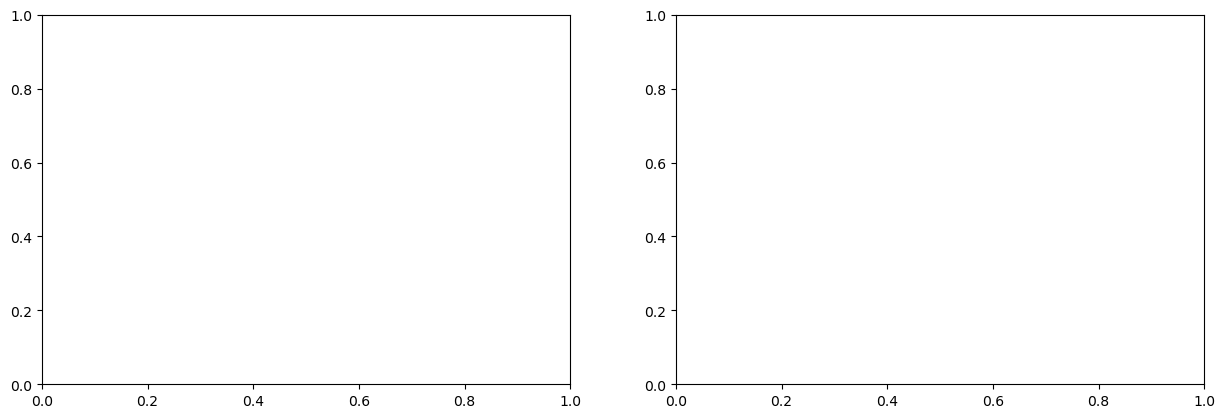

In [10]:
# seeing how the fixed parameters (not concerning phosphatase) contribute to the gradient

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0.25

# changing the difference between Df and Ds
Df=5


"""fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)"""
final_gradient = []
x=[]
"""
for i in np.linspace(0,5,20):
    Ds=Df-i
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    #axs[0].plot(t, MEG_gradient_strength, label=f"Df-Ds={i}")
    
    final_gradient.append(MEG_gradient_strength[-1])
    x.append(i)

plt.plot(np.linspace(0,5,20), final_gradient)
    
#axs[0].legend(loc='best')
#axs[0].set_title("Total MEG gradient over time")
plt.title("Final Polarisation Score")
plt.savefig('varyingDiffusionDifference.pdf') 
plt.show()

# Changing Kd for MEG RNA binding
Df=5
Ds=0.11

fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
final_gradient = []

for Kd in np.linspace(0, 50, 50):
    k2=k1*Kd
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    final_gradient.append(MEG_gradient_strength[-1])
    #axs[0].plot(t, MEG_gradient_strength, label=f"Kd={Kd}")
    
plt.plot(np.linspace(0, 50, 50), final_gradient)
    
#axs[0].legend(loc='best')
#axs[0].set_title("Total MEG gradient over time")
plt.title("Final Polarisation Score")
plt.savefig('varying_RNA_binding_Kd.pdf') 
plt.show()
"""
# Changing PLK-1 conc
k2=32*k1

fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
final_gradient = []

for PLK1 in np.linspace(0, 5000, 500):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    final_gradient.append(MEG_gradient_strength[-1])
   # axs[0].plot(t, MEG_gradient_strength, label=f"PLK-1 conc={PLK1}")
    
plt.plot(np.linspace(0, 5000, 500), final_gradient)
    
#axs[0].legend(loc='best')
#axs[0].set_title("Total MEG gradient over time")
plt.title("Final Polarisation Score")
plt.savefig('varying_PLK_conc.pdf')
plt.show()
"""
# Changing PLK-1 gradient
fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
final_gradient = []

for PLK1_gradient in np.linspace(0, 1, 10):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_gradient)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    final_gradient.append(MEG_gradient_strength[-1])
    #axs[0].plot(t, MEG_gradient_strength, label=f"PLK-1 gradient={PLK1_gradient}")
    
plt.plot(np.linspace(0, 1, 10), final_gradient)
    
#axs[0].legend(loc='best')
#axs[0].set_title("Total MEG gradient over time")
plt.title("Final Polarisation Score")
plt.savefig('varying_PLK_grad.pdf')
plt.show()
"""

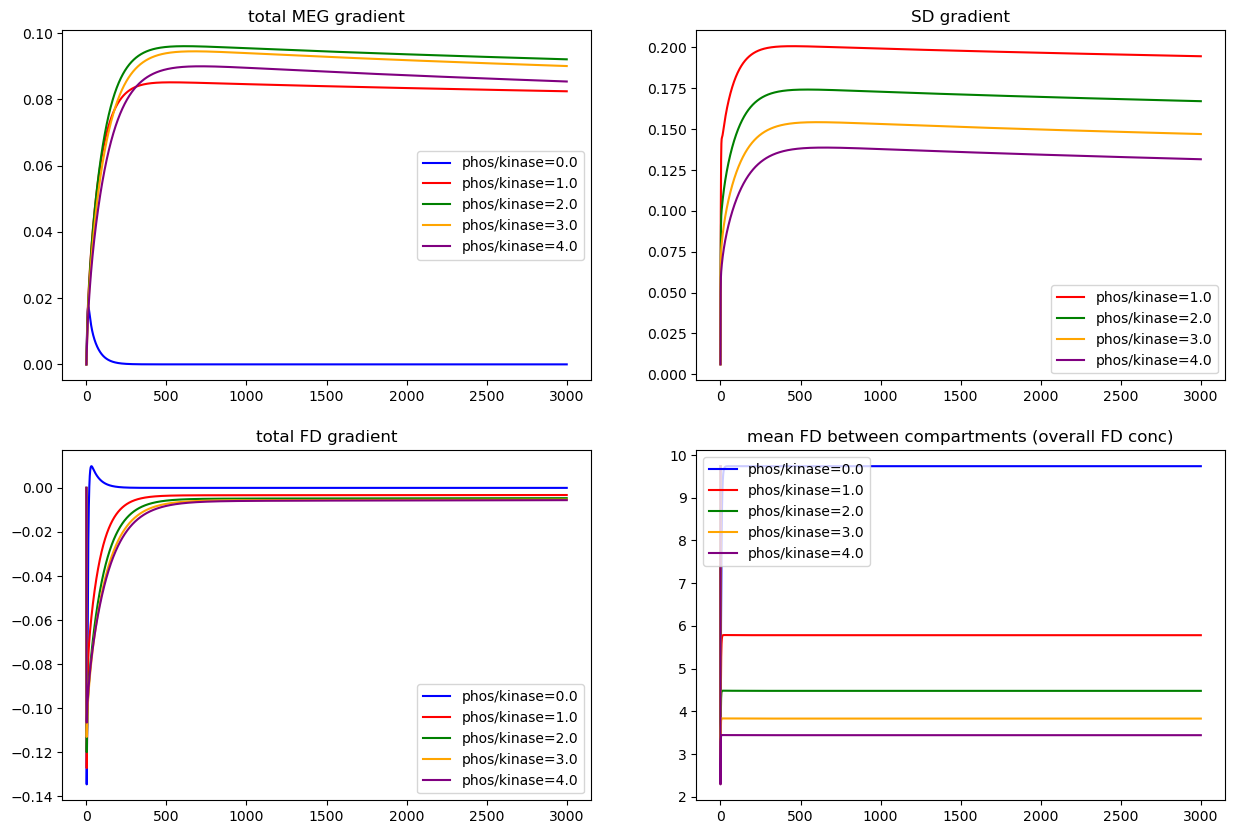

In [38]:
# varying phosphatase parameters

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0.25

# changing phosphatase concentration when phosphatase is uniform

fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)

colors = ['blue', 'red', 'green', 'orange', 'purple']

for count, phos_conc in enumerate(range(0, 5000, 1225)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, phos_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    axs[0,0].plot(t, MEG_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
    axs[0,0].legend(loc='best')
    axs[0,0].set_title('total MEG gradient')
    
    if phos_conc !=0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        axs[0,1].plot(t[1:], SD_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
        axs[0,1].legend(loc='best')
        axs[0,1].set_title('SD gradient')
    
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    axs[1,0].plot(t, FD_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
    axs[1,0].legend(loc='best')
    axs[1,0].set_title('total FD gradient')
    
    total_FD = np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    axs[1,1].plot(t, total_FD, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
    axs[1,1].legend(loc='best')
    axs[1,1].set_title('mean FD between compartments (overall FD conc)')
    
plt.show(fig)

# see below for more

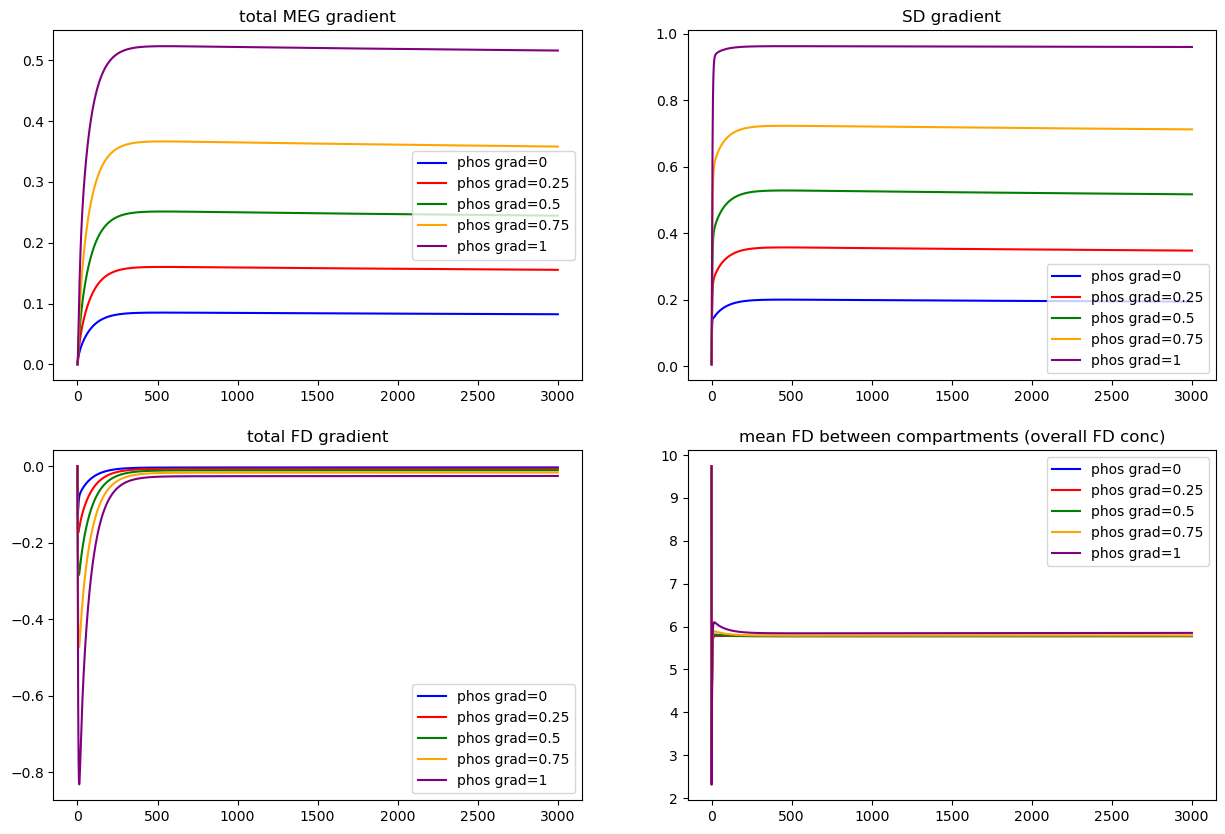

In [36]:
# changing the gradient of phosphatase

fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)

colors = ['blue', 'red', 'green', 'orange', 'purple']

for count, phos_gradient in enumerate((0, 0.25, 0.5, 0.75, 1)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, phos_gradient, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    axs[0,0].plot(t, MEG_gradient_strength, label=f"phos grad={phos_gradient}", color=colors[count])
    axs[0,0].legend(loc='best')
    axs[0,0].set_title('total MEG gradient')
    
    if phos_conc !=0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        axs[0,1].plot(t[1:], SD_gradient_strength, label=f"phos grad={phos_gradient}", color=colors[count])
        axs[0,1].legend(loc='best')
        axs[0,1].set_title('SD gradient')
    
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    axs[1,0].plot(t, FD_gradient_strength, label=f"phos grad={phos_gradient}", color=colors[count])
    axs[1,0].legend(loc='best')
    axs[1,0].set_title('total FD gradient')
    
    total_FD = np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    axs[1,1].plot(t, total_FD, label=f"phos grad={phos_gradient}", color=colors[count])
    axs[1,1].legend(loc='best')
    axs[1,1].set_title('mean FD between compartments (overall FD conc)')
    
plt.show(fig)

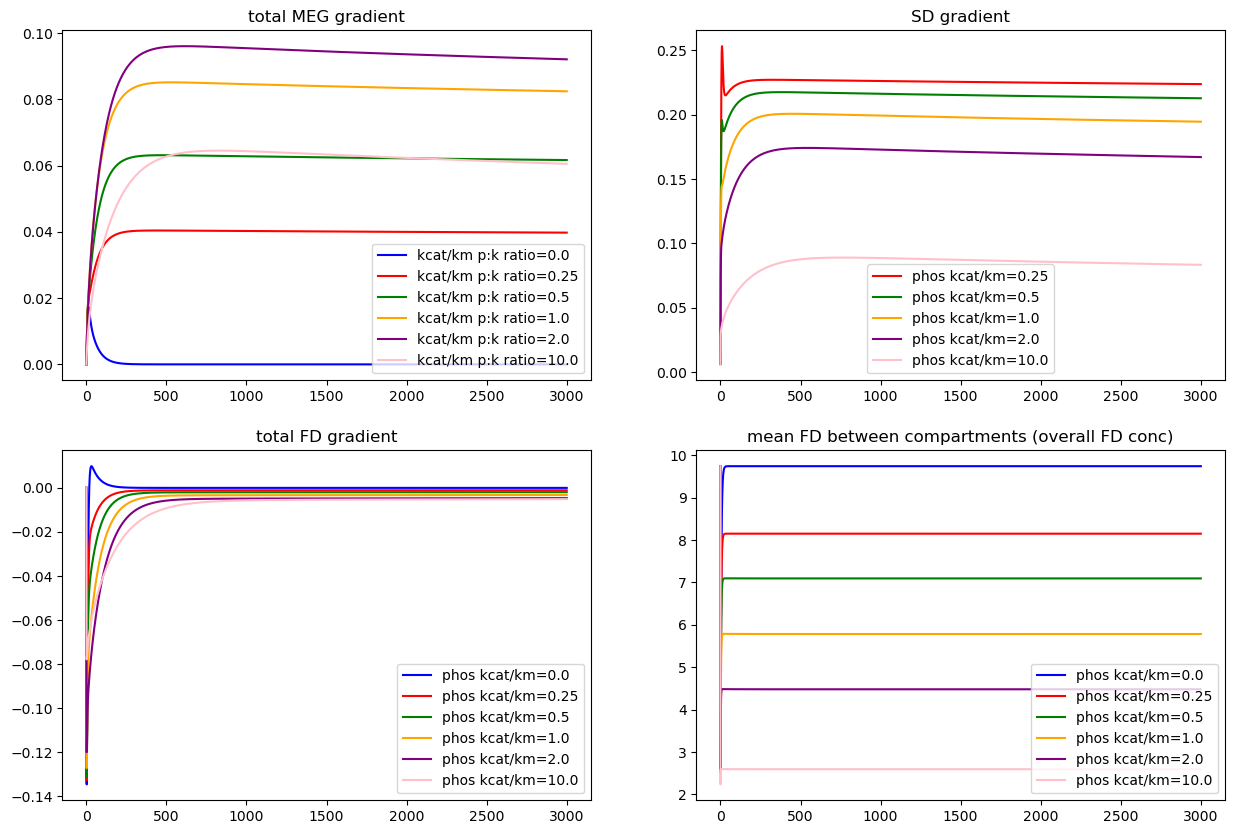

In [10]:
# changing phosphatase kcat/km when phosphatase is uniform

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0.25

fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(15)

colors = ['blue', 'red', 'green', 'orange', 'purple', 'pink']

for count, phos_kinetics in enumerate((0, 0.25*kcat2_km2, 0.5*kcat2_km2, kcat2_km2, 2*kcat2_km2, 10*kcat2_km2)):
    params=(N, phos_kinetics, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    axs[0,0].plot(t, MEG_gradient_strength, label=f"kcat/km p:k ratio={phos_kinetics/kcat2_km2}", color=colors[count])
    axs[0,0].legend(loc='best')
    axs[0,0].set_title('total MEG gradient')
    
    if phos_kinetics != 0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        axs[0,1].plot(t[1:], SD_gradient_strength, label=f"phos kcat/km={phos_kinetics/kcat2_km2}", color=colors[count])
        axs[0,1].legend(loc='best')
        axs[0,1].set_title('SD gradient')
    
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    axs[1,0].plot(t, FD_gradient_strength, label=f"phos kcat/km={phos_kinetics/kcat2_km2}", color=colors[count])
    axs[1,0].legend(loc='best')
    axs[1,0].set_title('total FD gradient')
    
    total_FD = np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    axs[1,1].plot(t, total_FD, label=f"phos kcat/km={phos_kinetics/kcat2_km2}", color=colors[count])
    axs[1,1].legend(loc='best')
    axs[1,1].set_title('mean FD between compartments (overall FD conc)')
    
plt.show(fig)

C:\Users\jenny\AppData\Local\Temp\ipykernel_13748\469616151.py:68: RuntimeWarning: invalid value encountered in divide
  MEG_phos_gradient_strength=1-anterior_MEG_phos/posterior_MEG_phos


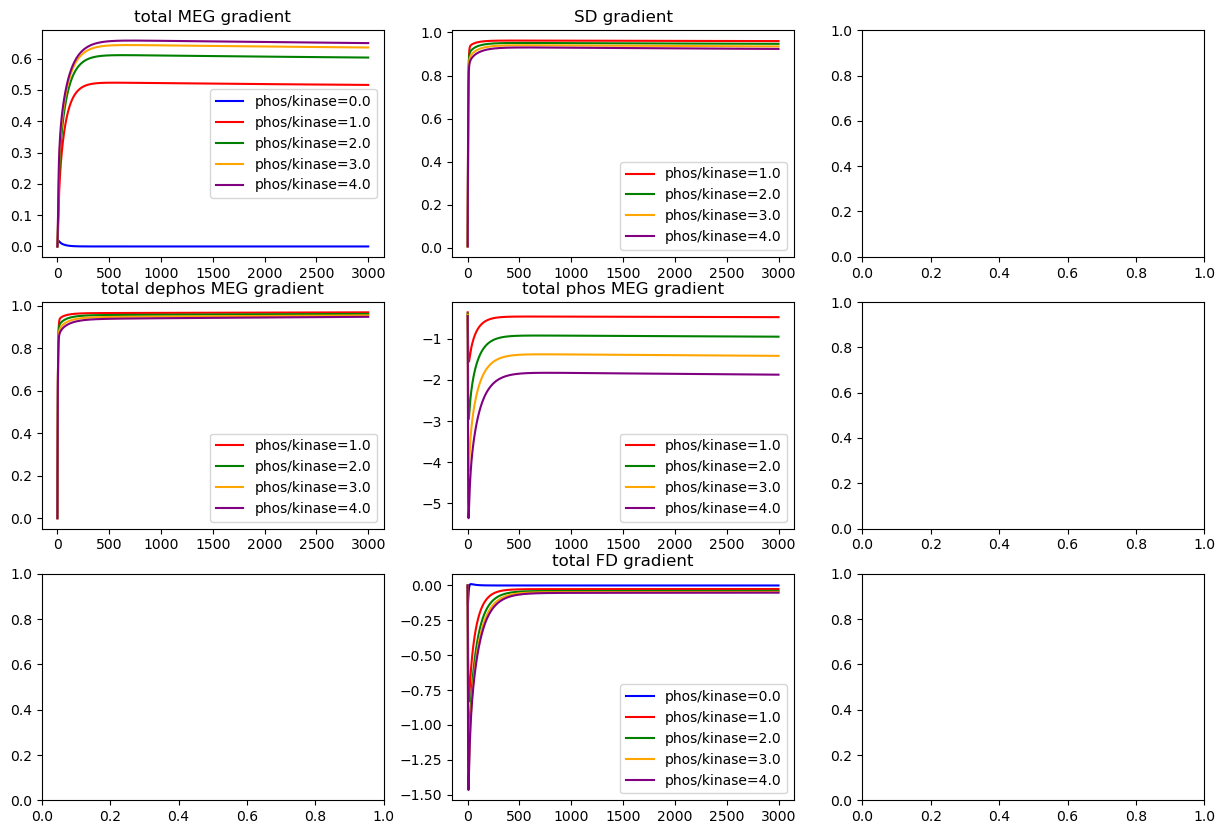

In [17]:
# changing phosphatase concentration when phosphatase is uniform

# CHANGED SOME STUFF WHILE TESTING - CHECK THESE PARAMS BEFORE RUNNING AGAIN
tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=1
PLK1_conc=1225
PLK1_grad=0.25

fig, axs = plt.subplots(3,3)
fig.set_figheight(10)
fig.set_figwidth(15)

colors = ['blue', 'red', 'green', 'orange', 'purple']

for count, phos_conc in enumerate(range(0, 5000, 1225)):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, phos_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    axs[0,0].plot(t, MEG_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
    axs[0,0].legend(loc='best')
    axs[0,0].set_title('total MEG gradient')
    
    if phos_conc !=0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        axs[0,1].plot(t[1:], SD_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
        axs[0,1].legend(loc='best')
        axs[0,1].set_title('SD gradient')
    
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    axs[2,1].plot(t, FD_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
    axs[2,1].legend(loc='best')
    axs[2,1].set_title('total FD gradient')
    
    if phos_conc !=0:
        posterior_MEG_dephos = sol[:, 0]
        anterior_MEG_dephos = sol[:, N-1]
        MEG_dephos_gradient_strength=1-anterior_MEG_dephos/posterior_MEG_dephos
        axs[1,0].plot(t, MEG_dephos_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
        axs[1,0].legend(loc='best')
        axs[1,0].set_title('total dephos MEG gradient')
    
    if phos_conc !=0:
        posterior_MEG_phos = sol[:, N]
        anterior_MEG_phos = sol[:, 2*N-1]
        MEG_phos_gradient_strength=1-anterior_MEG_phos/posterior_MEG_phos
        axs[1,1].plot(t, MEG_phos_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
        axs[1,1].legend(loc='best')
        axs[1,1].set_title('total phos MEG gradient')
    
plt.show(fig)

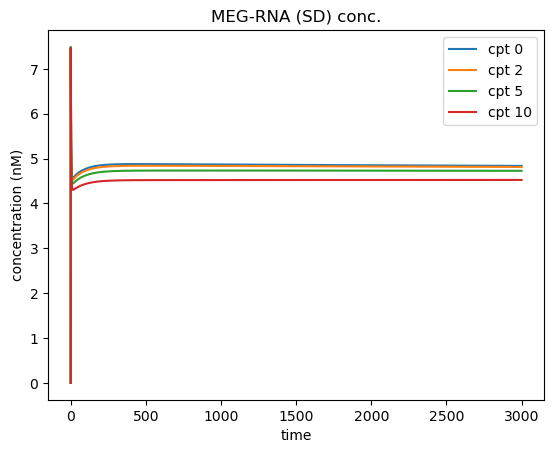

In [46]:
# seeing if SD is highest in posterior or just before posterior
# notes Wu et al measure relative number of molecules, not concentrations - here we are dealing with concentrations

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.25
PLK1_conc=1225
PLK1_grad=0.25

params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
sol=odeint(MEG_gradient, init, t, params) 

plt.plot(t, sol[:, 3*N], label="cpt 0")
plt.plot(t, sol[:, 3*N+2], label="cpt 2")
plt.plot(t, sol[:, 3*N+5], label="cpt 5")
plt.plot(t, sol[:, 3*N+10], label="cpt 10")
plt.title('MEG-RNA (SD) conc.')
plt.xlabel('time')
plt.ylabel('concentration (nM)')
plt.legend()
plt.show()

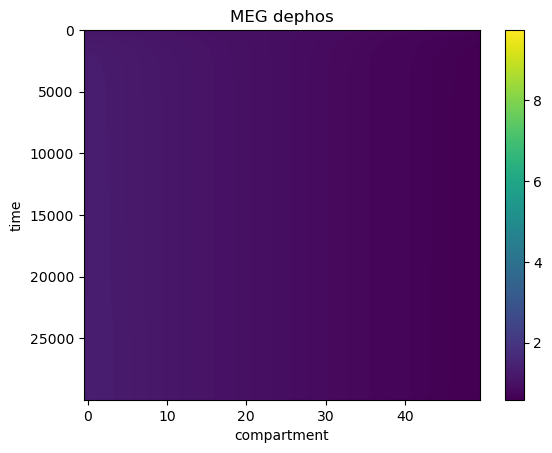

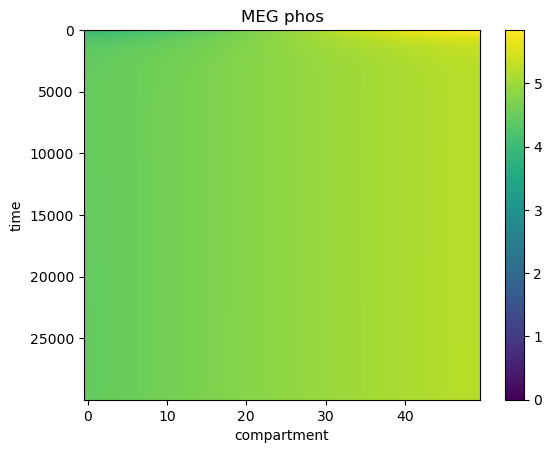

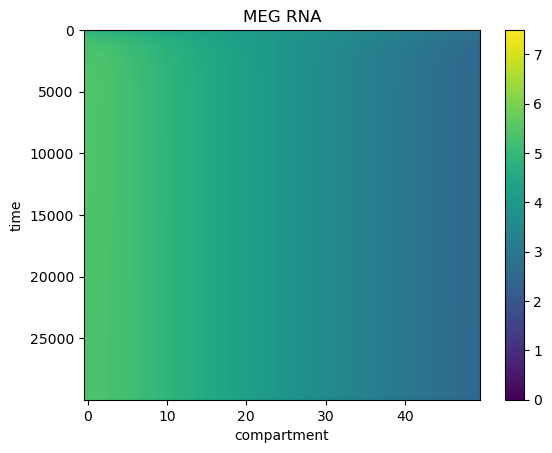

C:\Users\jenny\AppData\Local\Temp\ipykernel_13748\36919711.py:89: RuntimeWarning: invalid value encountered in divide
  MEG_phos_gradient_strength=1-anterior_MEG_phos/posterior_MEG_phos


Text(0.5, 1.0, 'mean FD between compartments (overall FD conc)')

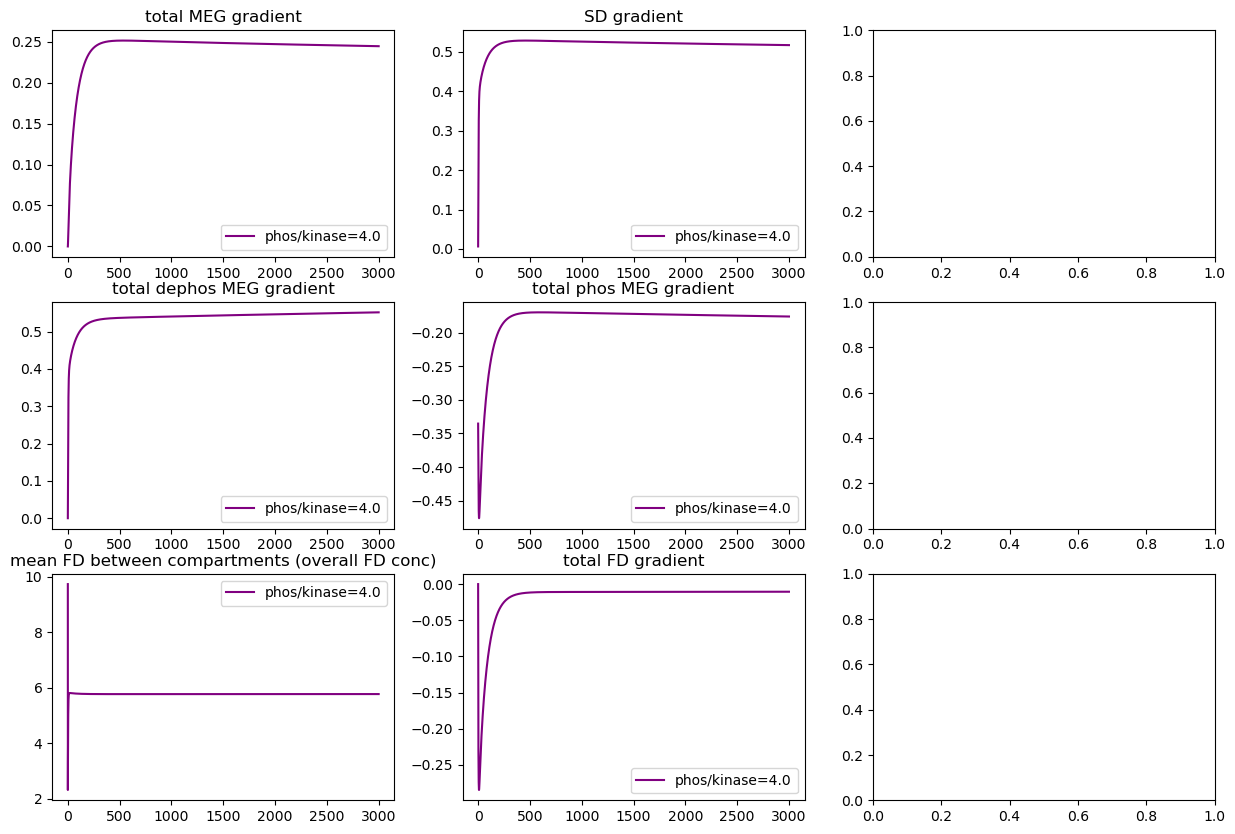

In [19]:
tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.5
PLK1_conc=1225
PLK1_grad=0.25

params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
sol=odeint(MEG_gradient, init, t, params)

colors = ['blue', 'red', 'green', 'orange', 'purple']

MEG_dephos = sol[:, range(N)]
cs = plt.imshow(MEG_dephos, aspect='auto')
plt.title('MEG dephos')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

MEG_phos=sol[:,range(N,2*N)]
cs = plt.imshow(MEG_phos, aspect='auto')
plt.title('MEG phos')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

MEG_RNA=sol[:,range(3*N,4*N)]
cs = plt.imshow(MEG_RNA, aspect='auto')
plt.title('MEG RNA')
plt.xlabel('compartment')
plt.ylabel('time')
plt.colorbar(cs)
plt.show()

fig, axs = plt.subplots(3,3)
fig.set_figheight(10)
fig.set_figwidth(15)

colors = ['blue', 'red', 'green', 'orange', 'purple']

posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
MEG_gradient_strength=1-anterior_MEG/posterior_MEG
axs[0,0].plot(t, MEG_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
axs[0,0].legend(loc='best')
axs[0,0].set_title('total MEG gradient')
    

posterior_SD = sol[1:, 3*N]
anterior_SD = sol[1:, 4*N-1]
SD_gradient_strength=1-anterior_SD/posterior_SD
axs[0,1].plot(t[1:], SD_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
axs[0,1].legend(loc='best')
axs[0,1].set_title('SD gradient')
    
posterior_FD = sol[:, 0]+sol[:, N]
anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
FD_gradient_strength=1-anterior_FD/posterior_FD
axs[2,1].plot(t, FD_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
axs[2,1].legend(loc='best')
axs[2,1].set_title('total FD gradient')
    

posterior_MEG_dephos = sol[:, 0]
anterior_MEG_dephos = sol[:, N-1]
MEG_dephos_gradient_strength=1-anterior_MEG_dephos/posterior_MEG_dephos
axs[1,0].plot(t, MEG_dephos_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
axs[1,0].legend(loc='best')
axs[1,0].set_title('total dephos MEG gradient')
    
posterior_MEG_phos = sol[:, N]
anterior_MEG_phos = sol[:, 2*N-1]
MEG_phos_gradient_strength=1-anterior_MEG_phos/posterior_MEG_phos
axs[1,1].plot(t, MEG_phos_gradient_strength, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
axs[1,1].legend(loc='best')
axs[1,1].set_title('total phos MEG gradient')

total_FD = np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
axs[2,0].plot(t, total_FD, label=f"phos/kinase={phos_conc/1225}", color=colors[count])
axs[2,0].legend(loc='best')
axs[2,0].set_title('mean FD between compartments (overall FD conc)')

In [38]:
# changing phosphatase kcat/km when phosphatase is uniform

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0.25

colors = ['blue', 'red', 'green', 'orange', 'purple', 'pink']
overall_MEG_grad=[]
SD_grad=[]
FD_grad=[]
mean_SD=[]
mean_FD=[]
total_SD=[]
total_FD=[]

for current in np.linspace(0,10,25):
    phos_kinetics=current*kcat2_km2
    params=(N, phos_kinetics, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    overall_MEG_grad.append(MEG_gradient_strength[-1])
    
    if phos_kinetics != 0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        SD_grad.append(SD_gradient_strength[-1])
    
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    FD_grad.append(FD_gradient_strength[-1])

    FD_overtime = np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    total_FD.append(FD_overtime[-1])
    SD_overtime = np.mean(sol[:, range(3*N,4*N)], axis=1)
    total_SD.append(SD_overtime[-1])
    


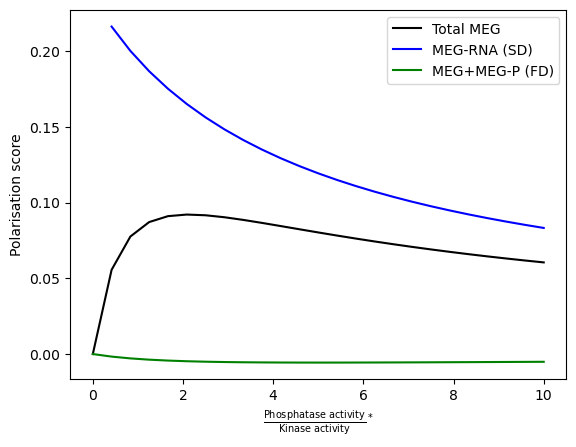

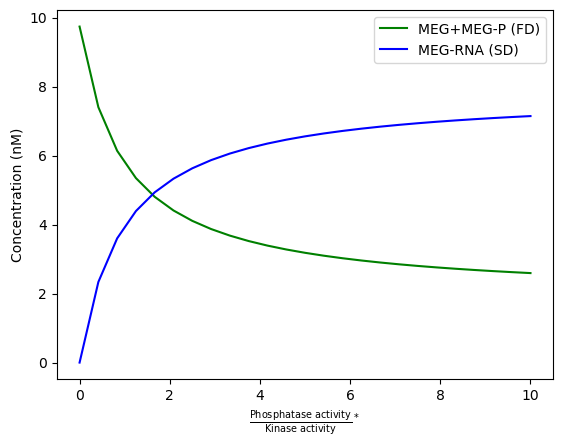

In [39]:
plt.plot(np.linspace(0,10,25), overall_MEG_grad, label = "Total MEG", color = "black")
plt.plot(np.linspace(0,10,25)[1:], SD_grad, label = "MEG-RNA (SD)", color = "blue")
plt.plot(np.linspace(0,10,25), FD_grad, label = "MEG+MEG-P (FD)", color = "green")
plt.xlabel(r'$\frac{\text{Phosphatase activity}}{\text{Kinase activity}}^*' + r'$')
plt.ylabel('Polarisation score')
plt.legend(loc='best')
plt.savefig("varying_pase_kinestics_polarisationscores.pdf")
plt.show()

plt.plot(np.linspace(0,10,25), total_FD, label = "MEG+MEG-P (FD)", color = "green")
plt.plot(np.linspace(0,10,25), total_SD, label = "MEG-RNA (SD)", color = "blue")
plt.xlabel(r'$\frac{\text{Phosphatase activity}}{\text{Kinase activity}}^*' + r'$')
plt.ylabel('Concentration (nM)')
plt.legend(loc='best')
plt.savefig("varying_pase_kinestics_FDSDconcs.pdf")
plt.show()

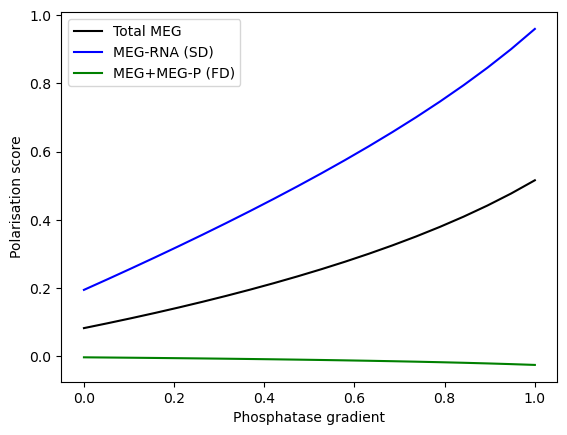

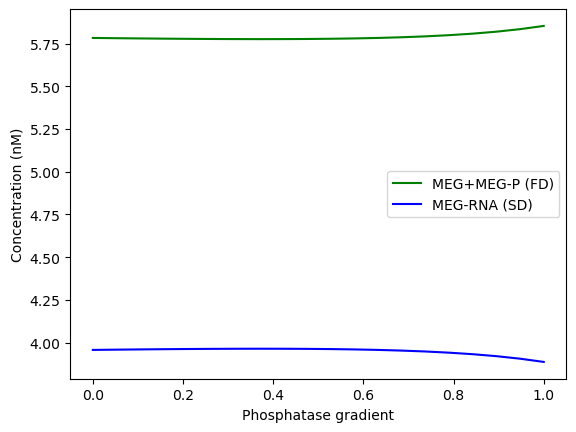

In [40]:
# changing phosphatase grad

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0.25

colors = ['blue', 'red', 'green', 'orange', 'purple', 'pink']
overall_MEG_grad=[]
SD_grad=[]
FD_grad=[]
mean_SD=[]
mean_FD=[]
total_FD=[]
total_SD=[]

for phos_gradient in np.linspace(0,1,20):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, phos_gradient, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    overall_MEG_grad.append(MEG_gradient_strength[-1])
   
    posterior_SD = sol[1:, 3*N]
    anterior_SD = sol[1:, 4*N-1]
    SD_gradient_strength=1-anterior_SD/posterior_SD
    SD_grad.append(SD_gradient_strength[-1])
   
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    FD_grad.append(FD_gradient_strength[-1])
   
    FD_overtime=np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    total_FD.append(FD_overtime[-1])
    SD_overtime=np.mean(sol[:, range(3*N,4*N)], axis=1)
    total_SD.append(SD_overtime[-1])
   
plt.plot(np.linspace(0,1,20), overall_MEG_grad, label = "Total MEG", color = "black")
plt.plot(np.linspace(0,1,20), SD_grad, label = "MEG-RNA (SD)", color = "blue")
plt.plot(np.linspace(0,1,20), FD_grad, label = "MEG+MEG-P (FD)", color = "green")
plt.xlabel('Phosphatase gradient')
plt.ylabel('Polarisation score')
plt.legend(loc='best')
plt.savefig("varying_pase_grad_polarisationscores.pdf")
plt.show()

plt.plot(np.linspace(0,1,20), total_FD, label = "MEG+MEG-P (FD)", color = "green")
plt.plot(np.linspace(0,1,20), total_SD, label = "MEG-RNA (SD)", color = "blue")
plt.xlabel('Phosphatase gradient')
plt.ylabel('Concentration (nM)')
plt.legend(loc='best')
plt.savefig("varying_pase_grad_FDSDconc.pdf")
plt.show()

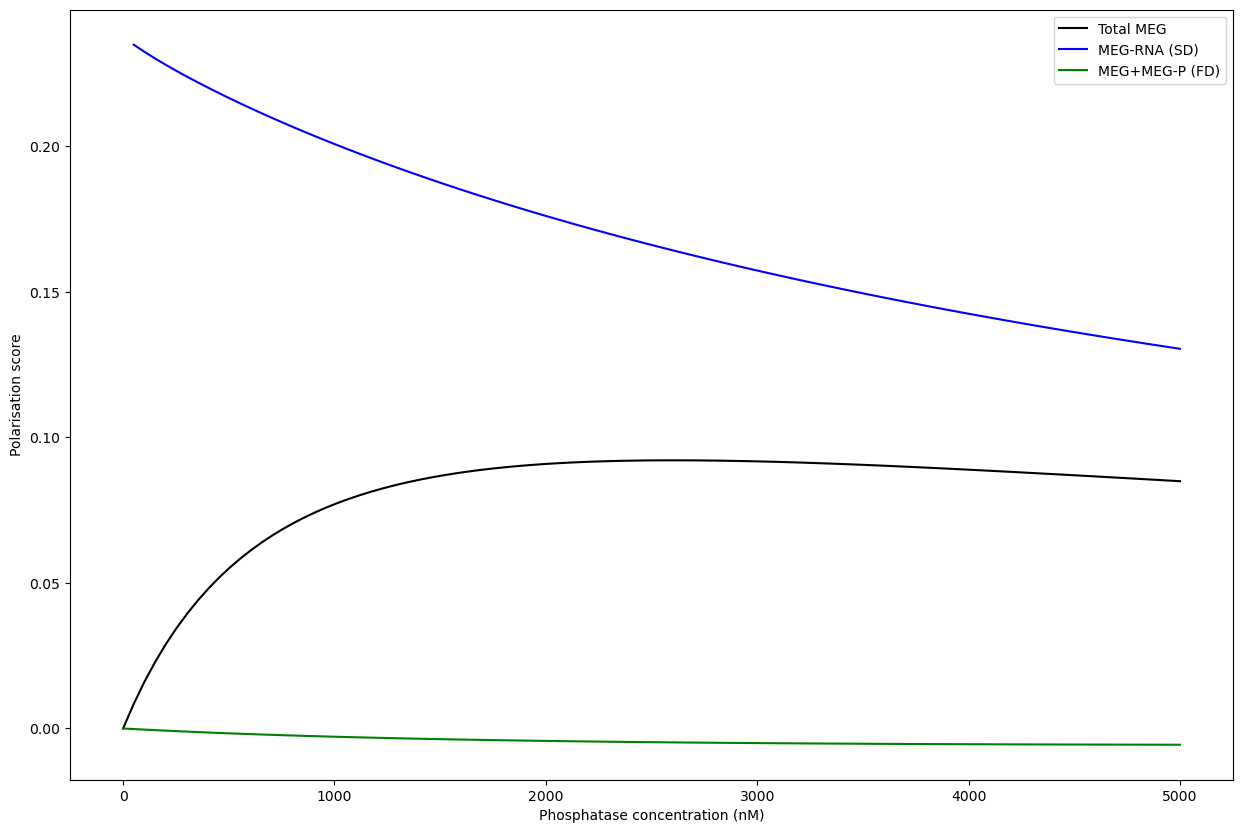

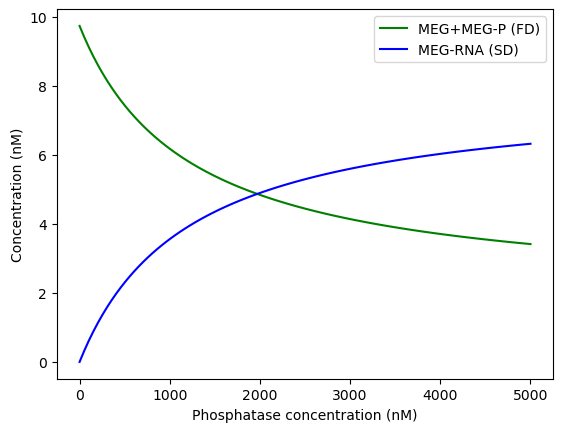

In [41]:
# changing phosphatase conc when phosphatase is uniform

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, np.ones(N)*150))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0
PLK1_conc=1225
PLK1_grad=0.25



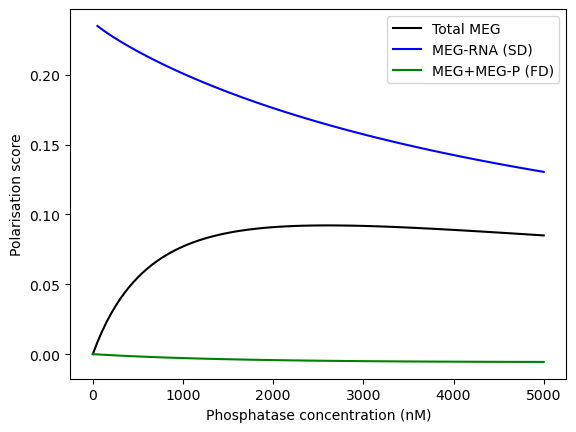

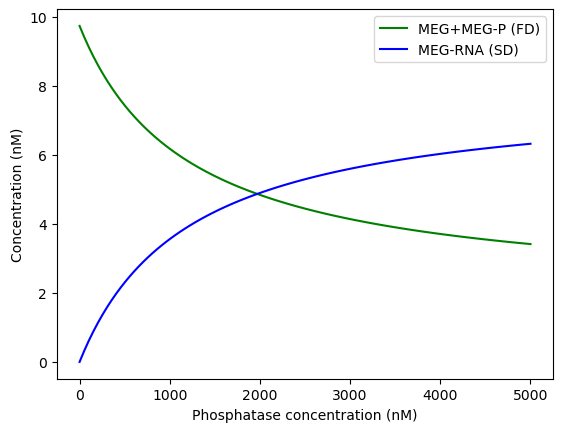

In [42]:
colors = ['blue', 'red', 'green', 'orange', 'purple', 'pink']
overall_MEG_grad=[]
SD_grad=[]
FD_grad=[]
mean_SD=[]
mean_FD=[]
total_FD=[]
total_SD=[]

for phos_conc in np.linspace(0,5000,100):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, phos_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    overall_MEG_grad.append(MEG_gradient_strength[-1])
   
    if phos_conc != 0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        SD_grad.append(SD_gradient_strength[-1])
   
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    FD_grad.append(FD_gradient_strength[-1])
   
    FD_overtime=np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    total_FD.append(FD_overtime[-1])
    SD_overtime=np.mean(sol[:, range(3*N,4*N)], axis=1)
    total_SD.append(SD_overtime[-1])
   
plt.plot(np.linspace(0,5000,100), overall_MEG_grad, label = "Total MEG", color = "black")
plt.plot(np.linspace(0,5000,100)[1:], SD_grad, label = "MEG-RNA (SD)", color = "blue")
plt.plot(np.linspace(0,5000,100), FD_grad, label = "MEG+MEG-P (FD)", color = "green")
plt.xlabel('Phosphatase concentration (nM)')
plt.ylabel('Polarisation score')
plt.legend(loc='best')
plt.savefig("varying_pase_conc_pol_scores.pdf")
plt.show()

plt.plot(np.linspace(0,5000,100), total_FD, label = "MEG+MEG-P (FD)", color = "green")
plt.plot(np.linspace(0,5000,100), total_SD, label = "MEG-RNA (SD)", color = "blue")
plt.xlabel('Phosphatase concentration (nM)')
plt.ylabel('Concentration (nM)')
plt.legend(loc='best')
plt.savefig("varying_pase_conc_FDSDconc.pdf")
plt.show()

In [91]:
# PLK-1 KO plot - most consistent with combining with RNA competition

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

 
k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.25
PLK1_conc=0
PLK1_grad=0.25
kcat_km=1.8*10**(-4)

RNA_overall_conc=75
RNA_grad=0
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))

params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
noRNAcomp=odeint(MEG_gradient, init, t, params)

RNA_overall_conc=75
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))

params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
withRNAcomp=odeint(MEG_gradient, init, t, params)

Pase_grad=0.53
params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
RNAcomp_plus_paseinhib=odeint(MEG_gradient, init, t, params)

noRNAcomp_posterior_SD = noRNAcomp[1:, 3*N]
noRNAcomp_anterior_SD = noRNAcomp[1:, 4*N-1]
noRNAcomp_SD_gradient_strength=1-noRNAcomp_anterior_SD/noRNAcomp_posterior_SD

withRNAcomp_posterior_SD = withRNAcomp[1:, 3*N]
withRNAcomp_anterior_SD = withRNAcomp[1:, 4*N-1]
withRNAcomp_SD_gradient_strength=1-withRNAcomp_anterior_SD/withRNAcomp_posterior_SD

RNAcomp_plus_paseinhib_posterior_SD = RNAcomp_plus_paseinhib[1:, 3*N]
RNAcomp_plus_paseinhib_anterior_SD = RNAcomp_plus_paseinhib[1:, 4*N-1]
RNAcomp_plus_paseinhib_SD_gradient_strength=1-RNAcomp_plus_paseinhib_anterior_SD/RNAcomp_plus_paseinhib_posterior_SD


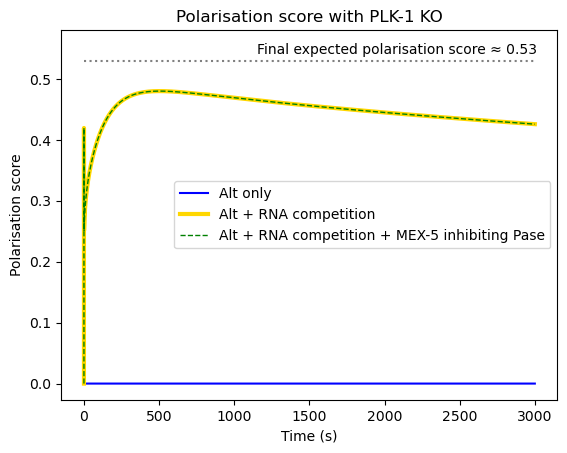

In [92]:
noRNAcomp_SD_gradient_strength=np.insert(noRNAcomp_SD_gradient_strength,0,0)
withRNAcomp_SD_gradient_strength=np.insert(withRNAcomp_SD_gradient_strength,0,0)
RNAcomp_plus_paseinhib_SD_gradient_strength=np.insert(RNAcomp_plus_paseinhib_SD_gradient_strength,0,0)

plt.plot(t, noRNAcomp_SD_gradient_strength, label="Alt only", color='blue')
plt.plot(t, withRNAcomp_SD_gradient_strength, label="Alt + RNA competition", linewidth=3, color='gold')
plt.plot(t, RNAcomp_plus_paseinhib_SD_gradient_strength, label="Alt + RNA competition + MEX-5 inhibiting Pase", linestyle='--', linewidth=1, color='green')
plt.hlines(0.53, 0, 3000, linestyle=':', color='grey')
plt.annotate('Final expected polarisation score ≈ 0.53', xy=(1150, 0.53), xytext=(0, 5), textcoords='offset points')
plt.legend(loc='right')
plt.title('Polarisation score with PLK-1 KO')
plt.xlabel('Time (s)')
plt.ylabel('Polarisation score')
plt.ylim(top=0.58)
plt.savefig("Pol_score_PLK1KO.pdf")
plt.show()

In [ ]:
# MEX-5 KO plot

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

 
k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.25
PLK1_conc=1225
PLK1_grad=0
kcat_km=1.8*10**(-4)

RNA_overall_conc=150
RNA_grad=0
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))

params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
noRNAcomp=odeint(MEG_gradient, init, t, params)

RNA_overall_conc=150
RNA_grad=0
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))

params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
withRNAcomp=odeint(MEG_gradient, init, t, params)

Pase_grad=0
params=(N, kcat_km, kcat_km, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
RNAcomp_plus_paseinhib=odeint(MEG_gradient, init, t, params)

noRNAcomp_posterior_SD = noRNAcomp[1:, 3*N]
noRNAcomp_anterior_SD = noRNAcomp[1:, 4*N-1]
noRNAcomp_SD_gradient_strength=1-noRNAcomp_anterior_SD/noRNAcomp_posterior_SD

withRNAcomp_posterior_SD = withRNAcomp[1:, 3*N]
withRNAcomp_anterior_SD = withRNAcomp[1:, 4*N-1]
withRNAcomp_SD_gradient_strength=1-withRNAcomp_anterior_SD/withRNAcomp_posterior_SD

RNAcomp_plus_paseinhib_posterior_SD = RNAcomp_plus_paseinhib[1:, 3*N]
RNAcomp_plus_paseinhib_anterior_SD = RNAcomp_plus_paseinhib[1:, 4*N-1]
RNAcomp_plus_paseinhib_SD_gradient_strength=1-RNAcomp_plus_paseinhib_anterior_SD/RNAcomp_plus_paseinhib_posterior_SD

In [ ]:
plt.plot(t[1:], noRNAcomp_SD_gradient_strength, label="Alt only", linewidth=3, color='gold')
plt.plot(t[1:], withRNAcomp_SD_gradient_strength, label="Alt + RNA competition",linestyle='--', linewidth=1, color='green')
plt.plot(t[1:], RNAcomp_plus_paseinhib_SD_gradient_strength, label="Alt + RNA competition + MEX-5 inhibiting Pase", color='blue')
plt.annotate('Final expected polarisation score ≈ 0.0', xy=(1150, 0.001), xytext=(0, 5), textcoords='offset points')
plt.legend(loc='best')
plt.title("SD polarisation over time with MEX-5 KO")
plt.xlabel('Time (s)')
plt.ylabel('Polarisation score')
plt.savefig("Pol_score_MEX5KO.pdf")
plt.show()

In [47]:
# WT varying phosphatase params

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

RNA_overall_conc=75
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25

colors = ['blue', 'red', 'green', 'orange', 'purple', 'pink']
overall_MEG_grad=[]
SD_grad=[]
FD_grad=[]
total_SD=[]
total_FD=[]

for i in np.linspace(10**(-6),10**(-3),100):
    phos_kinetics=i
    params=(N, phos_kinetics, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    overall_MEG_grad.append(MEG_gradient_strength[-1])
   
    if phos_kinetics != 0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        SD_grad.append(SD_gradient_strength[-1])
   
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    FD_grad.append(FD_gradient_strength[-1])
   
    FD_overtime=np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    total_FD.append(FD_overtime[-1])
    SD_overtime=np.mean(sol[:, range(3*N,4*N)], axis=1)
    total_SD.append(SD_overtime[-1])

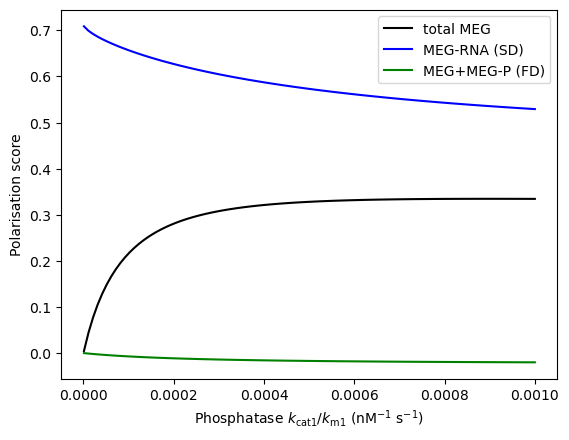

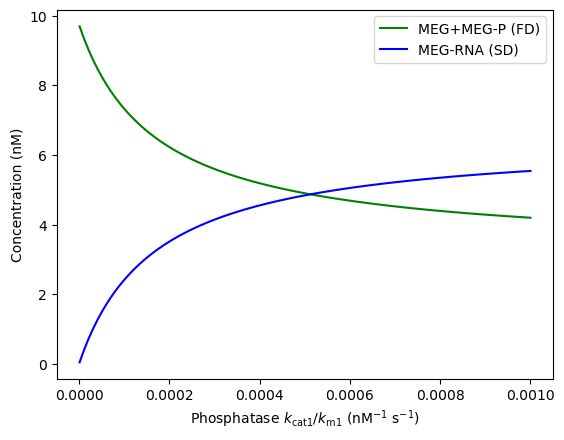

In [48]:
plt.plot(np.linspace(10**(-6),10**(-3),100), overall_MEG_grad, label="total MEG", color="black")
plt.plot(np.linspace(10**(-6),10**(-3),100), SD_grad, label="MEG-RNA (SD)", color="blue")
plt.plot(np.linspace(10**(-6),10**(-3),100), FD_grad, label="MEG+MEG-P (FD)", color="green")
plt.xlabel(r'Phosphatase $k_{\text{cat1}}/k_{\text{m1}}$ (nM$^{-1}$ s$^{-1}$)')  
plt.ylabel('Polarisation score')
plt.legend(loc='best')
plt.savefig("WT_varying_pase_kinetics_pol_scores.pdf")
plt.show()

plt.plot(np.linspace(10**(-6),10**(-3),100), total_FD, label="MEG+MEG-P (FD)", color="green")
plt.plot(np.linspace(10**(-6),10**(-3),100), total_SD, label="MEG-RNA (SD)", color="blue")
plt.xlabel(r'Phosphatase $k_{\text{cat1}}/k_{\text{m1}}$ (nM$^{-1}$ s$^{-1}$)')  
plt.ylabel('Concentration (nM)')
plt.legend(loc='best')
plt.savefig("WT_varying_pase_kinetics_FDSDconcs.pdf")
plt.show()

In [43]:


tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

RNA_overall_conc=75
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))

kcat1_km1=1.8*10**(-4) # phosphatase
kcat2_km2=1.8*10**(-4) # PLK-1
k1=0.1
k2=32*k1
Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25

colors = ['blue', 'red', 'green', 'orange', 'purple', 'pink']

overall_MEG_grad=[]
SD_grad=[]
FD_grad=[]
total_SD=[]
total_FD=[]
for phos_conc in np.linspace(0,5000,100):
    params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, phos_conc, Pase_grad, PLK1_conc, PLK1_grad)
    sol=odeint(MEG_gradient, init, t, params)

    posterior_MEG = sol[:, 0]+sol[:, N]+sol[:, 3*N]
    anterior_MEG = sol[:, N-1]+sol[:, 2*N-1]+sol[:, 4*N-1]
    MEG_gradient_strength=1-anterior_MEG/posterior_MEG
    overall_MEG_grad.append(MEG_gradient_strength[-1])
   
    if phos_conc != 0:
        posterior_SD = sol[1:, 3*N]
        anterior_SD = sol[1:, 4*N-1]
        SD_gradient_strength=1-anterior_SD/posterior_SD
        SD_grad.append(SD_gradient_strength[-1])
   
    posterior_FD = sol[:, 0]+sol[:, N]
    anterior_FD = sol[:, N-1]+sol[:, 2*N-1]
    FD_gradient_strength=1-anterior_FD/posterior_FD
    FD_grad.append(FD_gradient_strength[-1])
   
    FD_overtime=np.mean(sol[:, range(N,2*N)]+sol[:, range(0,N)], axis=1)
    total_FD.append(FD_overtime[-1])
    SD_overtime=np.mean(sol[:, range(3*N,4*N)], axis=1)
    total_SD.append(SD_overtime[-1])
   


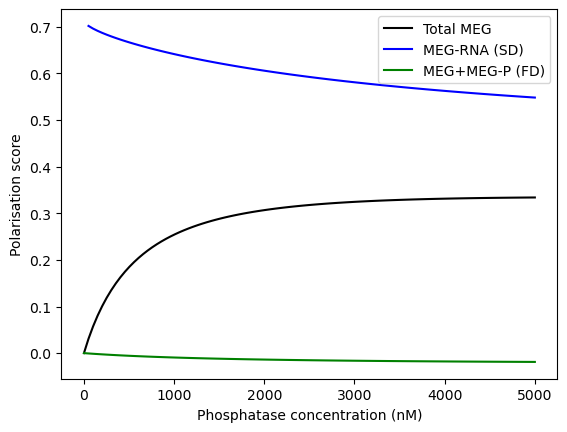

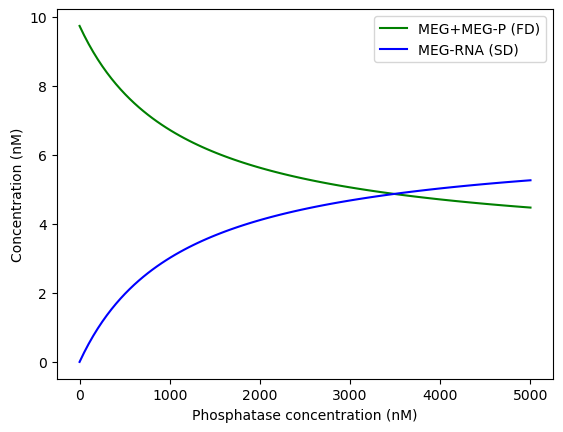

In [44]:
plt.plot(np.linspace(0,5000,100), overall_MEG_grad, label = "Total MEG", color="black")
plt.plot(np.linspace(0,5000,100)[1:], SD_grad, label = "MEG-RNA (SD)", color="blue")
plt.plot(np.linspace(0,5000,100), FD_grad, label = "MEG+MEG-P (FD)", color="green")
plt.xlabel('Phosphatase concentration (nM)')
plt.ylabel('Polarisation score')
plt.legend(loc='best')
plt.savefig("WT_varying_pase_conc_pol_scores.pdf")
plt.show()

plt.plot(np.linspace(0,5000,100), total_FD, label = "MEG+MEG-P (FD)", color="green")
plt.plot(np.linspace(0,5000,100), total_SD, label = "MEG-RNA (SD)", color="blue")
plt.xlabel('Phosphatase concentration (nM)')
plt.ylabel('Concentration (nM)')
plt.legend(loc='best')
plt.savefig("WT_varying_pase_conc_FDSDconc.pdf")
plt.show()

In [51]:
# final WT model

tStart=0
tEnd=3000
t=np.arange(tStart, tEnd, 0.1)

N=50

RNA_overall_conc=75
RNA_grad=0.53
x=2*RNA_overall_conc/(2-RNA_grad)
RNA_conc = np.linspace(x,(1-RNA_grad)*x, N)

init=np.concatenate((np.ones(N)*9.74, np.zeros(N)))
init=np.concatenate((init, RNA_conc))
init=np.concatenate((init, np.zeros(N)))
 
k1=0.1
k2=32*k1

Df=5
Ds=0.11
Pase_conc=1225
Pase_grad=0.53
PLK1_conc=1225
PLK1_grad=0.25
kcat1_km1=1.8*10**(-4)
kcat2_km2=1.8*10**(-4)

params=(N, kcat1_km1, kcat2_km2, k1, k2, Df, Ds, Pase_conc, Pase_grad, PLK1_conc, PLK1_grad)
final_WT_sol=odeint(MEG_gradient, init, t, params)

# gradient plot
posterior_MEG = final_WT_sol[:, 0]+final_WT_sol[:, N]+final_WT_sol[:, 3*N]
anterior_MEG = final_WT_sol[:, N-1]+final_WT_sol[:, 2*N-1]+final_WT_sol[:, 4*N-1]
MEG_gradient_strength=1-anterior_MEG/posterior_MEG
   
posterior_SD = final_WT_sol[1:, 3*N]
anterior_SD = final_WT_sol[1:, 4*N-1]
SD_gradient_strength=1-anterior_SD/posterior_SD
SD_gradient_strength=np.insert(SD_gradient_strength,0,0)
 
posterior_FD = final_WT_sol[:, 0]+final_WT_sol[:, N]
anterior_FD = final_WT_sol[:, N-1]+final_WT_sol[:, 2*N-1]
FD_gradient_strength=1-anterior_FD/posterior_FD


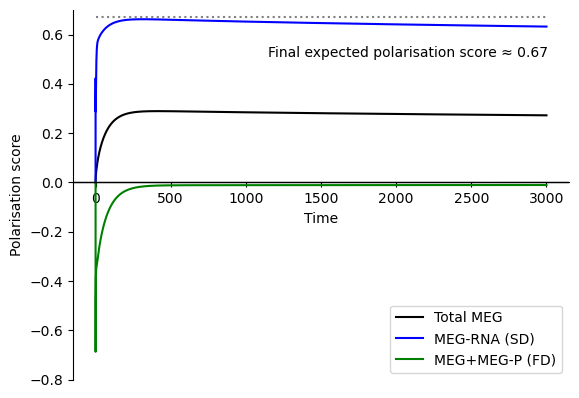

In [52]:
plt.plot(t, MEG_gradient_strength, label="Total MEG", color="black")
plt.plot(t, SD_gradient_strength, label="MEG-RNA (SD)", color="blue")
plt.plot(t, FD_gradient_strength, label="MEG+MEG-P (FD)", color="green")
plt.hlines(0.67, 0, 3000, linestyle=':', color='grey')
plt.annotate('Final expected polarisation score ≈ 0.67', xy=(1150, 0.48), xytext=(0, 5), textcoords='offset points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Polarisation score')

plt.ylim(-0.8, 0.7)
plt.axhline(y=0, color='black', linewidth=1)

# Adjust the spines to move the x-axis to y=0
ax = plt.gca()  # Get current axis
ax.spines['bottom'].set_position(('data', 0))
# Hide the top and right spines to make the plot cleaner
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("final_WT_gradient.pdf")
plt.show()

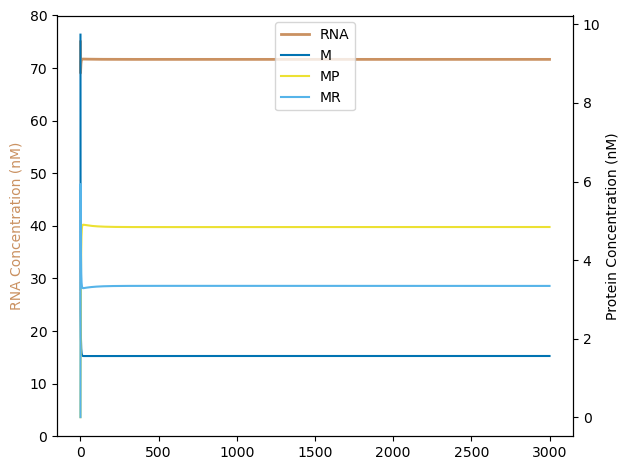

In [97]:
# concentration of everything plot
mean_M = np.mean(final_WT_sol[:, range(0, N)], axis=1)
mean_MP = np.mean(final_WT_sol[:, range(N, 2 * N)], axis=1)
mean_R = np.mean(final_WT_sol[:, range(2 * N, 3 * N)], axis=1)
mean_MR = np.mean(final_WT_sol[:, range(3 * N, 4 * N)], axis=1)

fig, ax2 = plt.subplots()
ax2.set_ylabel('RNA Concentration (nM)',color="#CA9161")  
ax2.plot(t, mean_R, label="RNA", color="#CA9161",linewidth=2)
ax2.tick_params(axis='y')
ax2.set_ylim(0,80)

ax1 = ax2.twinx() 
ax1.set_xlabel('Time')
ax1.set_ylabel('Protein Concentration (nM)')
ax1.plot(t, mean_M, label="M", color="#0173B2")
ax1.plot(t, mean_MP, label="MP", color="#ECE133")
ax1.plot(t, mean_MR, label="MR", color="#56B4E9")
ax1.tick_params(axis='y') 

fig.tight_layout()  
handles1, labels1 = ax2.get_legend_handles_labels()
handles2, labels2 = ax1.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper center')

plt.savefig("final_WT_concentration_everything.pdf")
plt.show()


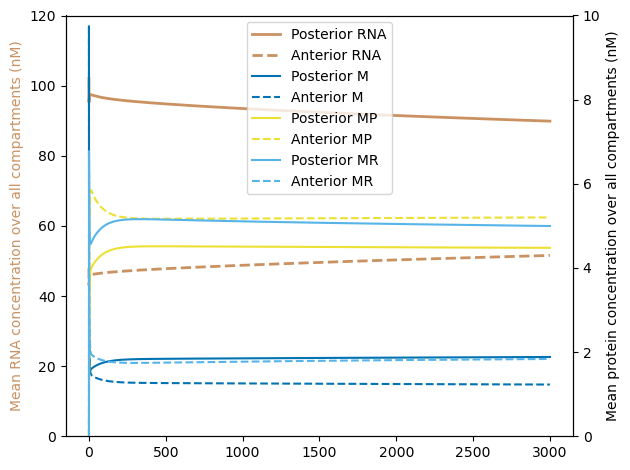

In [98]:
# concentration of everything in anterior vs posterior plot

fig, ax2 = plt.subplots()

ax2.set_ylabel('Mean RNA concentration over all compartments (nM)', color="#CA9161")
ax2.plot(t, final_WT_sol[:, 2*N], label="Posterior RNA", color="#CA9161",linewidth=2)
ax2.plot(t, final_WT_sol[:, 3*N-1], label="Anterior RNA", color="#CA9161", linestyle="--",linewidth=2)
ax2.set_ylim(0,120)
ax2.tick_params(axis='y')

ax1 = ax2.twinx() 
ax1.set_xlabel('Time')
ax1.set_ylabel('Mean protein concentration over all compartments (nM)')
ax1.plot(t, final_WT_sol[:, 0], label="Posterior M",color="#0173B2")
ax1.plot(t, final_WT_sol[:, N-1], label="Anterior M",color="#0173B2",linestyle="--")
ax1.plot(t, final_WT_sol[:, N], label="Posterior MP", color="#ECE133")
ax1.plot(t, final_WT_sol[:, 2*N-1], label="Anterior MP",color="#ECE133",linestyle="--")
ax1.plot(t, final_WT_sol[:, 3*N], label="Posterior MR", color="#56B4E9")
ax1.plot(t, final_WT_sol[:, 4*N-1], label="Anterior MR", color="#56B4E9",linestyle="--")
ax1.set_ylim(0,10)
ax1.tick_params(axis='y') 

fig.tight_layout()  
handles1, labels1 = ax2.get_legend_handles_labels()
handles2, labels2 = ax1.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper center')
plt.savefig("final_WT_conc_everything_ant_vs_post.pdf")
plt.show()

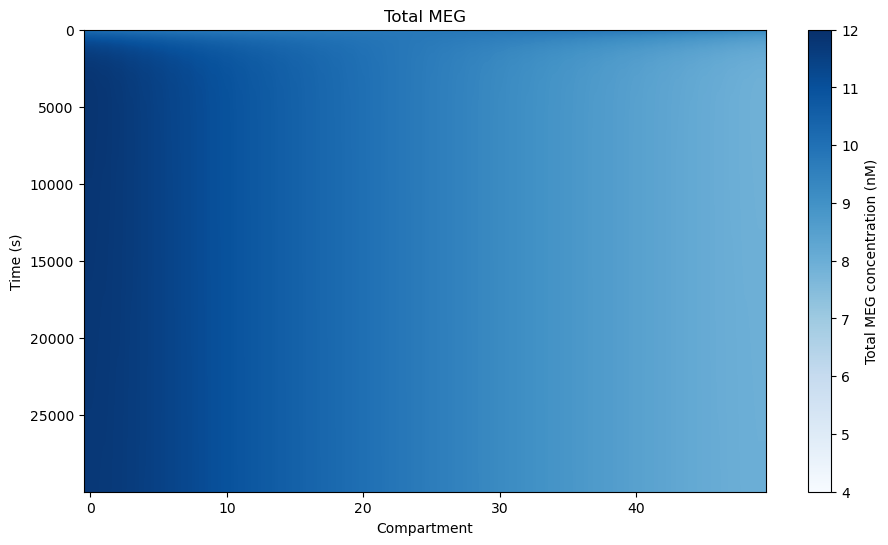

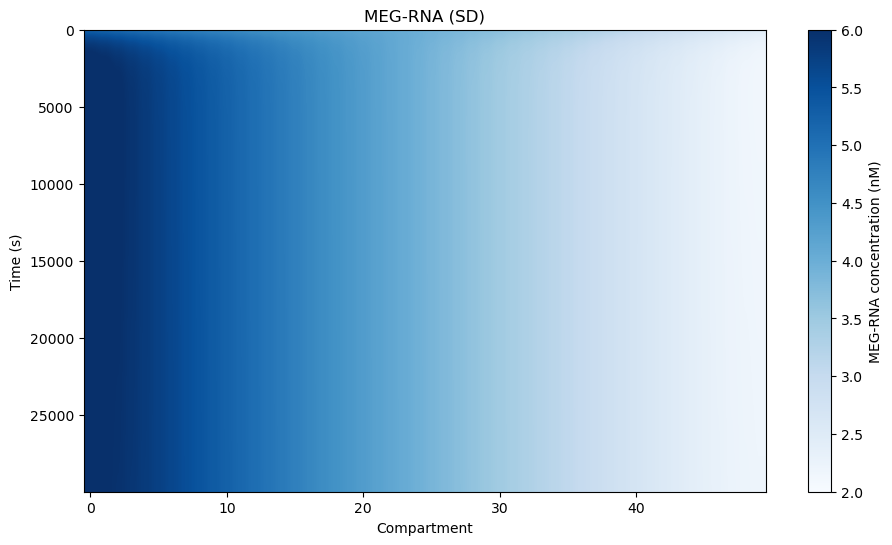

In [80]:
total_MEG = final_WT_sol[:, range(N)]+final_WT_sol[:,range(N,2*N)]+final_WT_sol[:,range(3*N,4*N)]
fig, ax = plt.subplots(figsize=(11, 6)) 
cs = plt.imshow(total_MEG, aspect='auto', cmap='Blues', vmin=4, vmax=12)
ax.set_title('Total MEG')
ax.set_xlabel('Compartment')
ax.set_ylabel('Time (s)')
cbar = fig.colorbar(cs)
cbar.set_label('Total MEG concentration (nM)')
plt.show()


SD_MEG = final_WT_sol[:,range(3*N,4*N)]
fig, ax = plt.subplots(figsize=(11, 6)) 
cs = plt.imshow(SD_MEG, aspect='auto', cmap='Blues', vmin=2, vmax=6)
ax.set_title('MEG-RNA (SD)')
ax.set_xlabel('Compartment')
ax.set_ylabel('Time (s)')
cbar = fig.colorbar(cs)
cbar.set_label('MEG-RNA concentration (nM)')
plt.savefig("MEG_RNA_heat_map.pdf")
plt.show()

# change the colorur bars to say >12 at top, <4 at the bottom, etc.

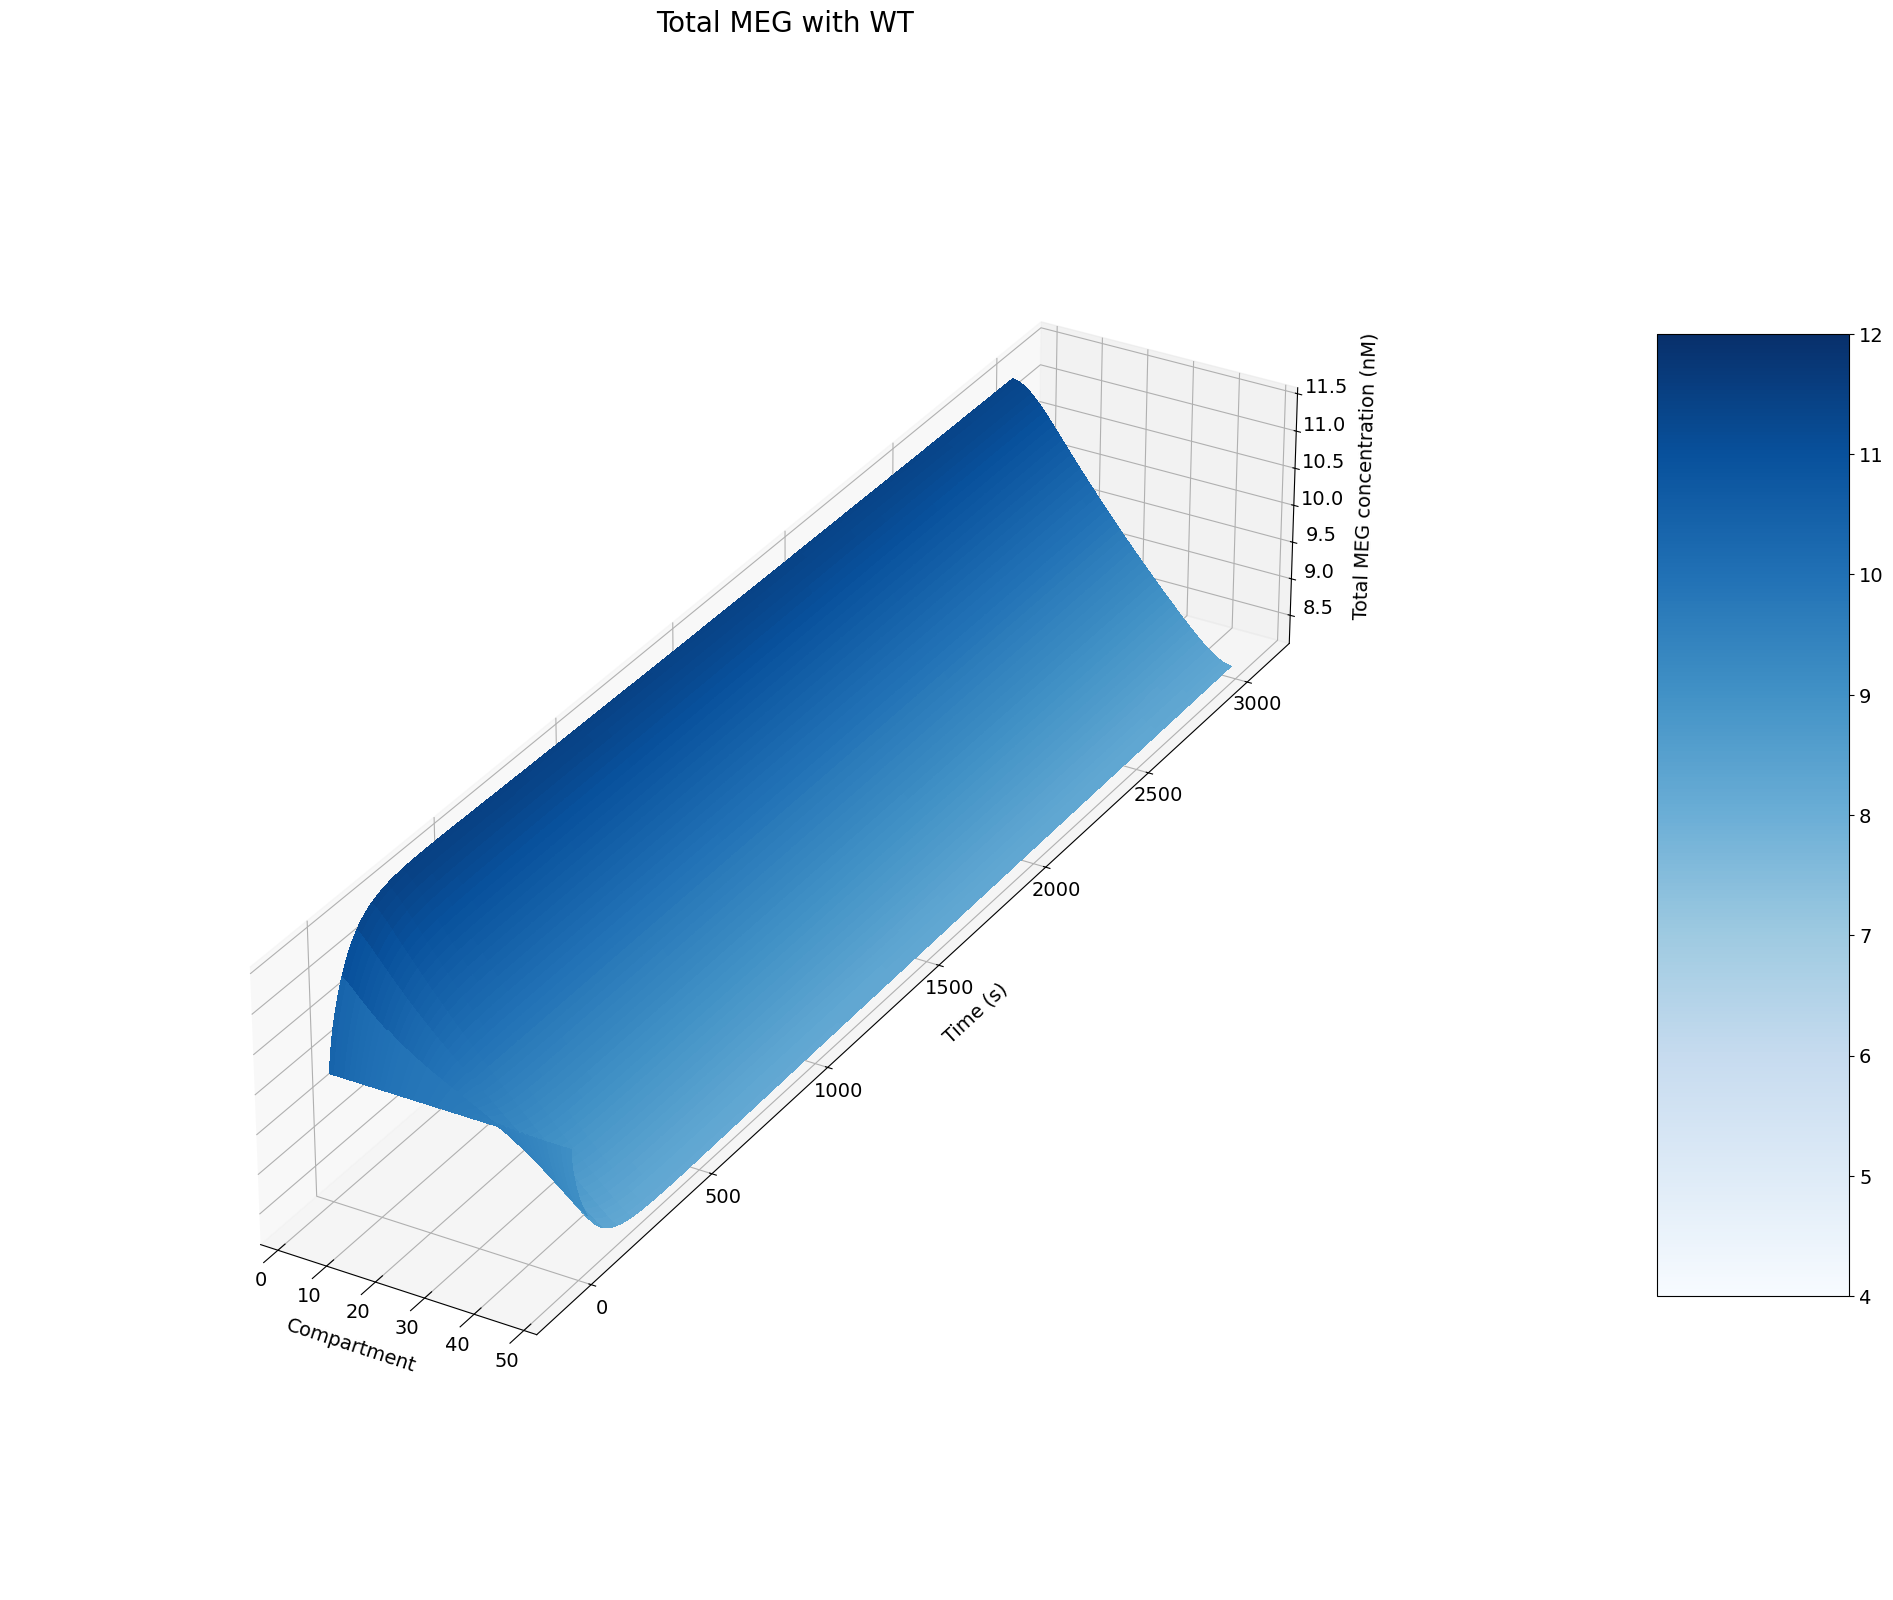

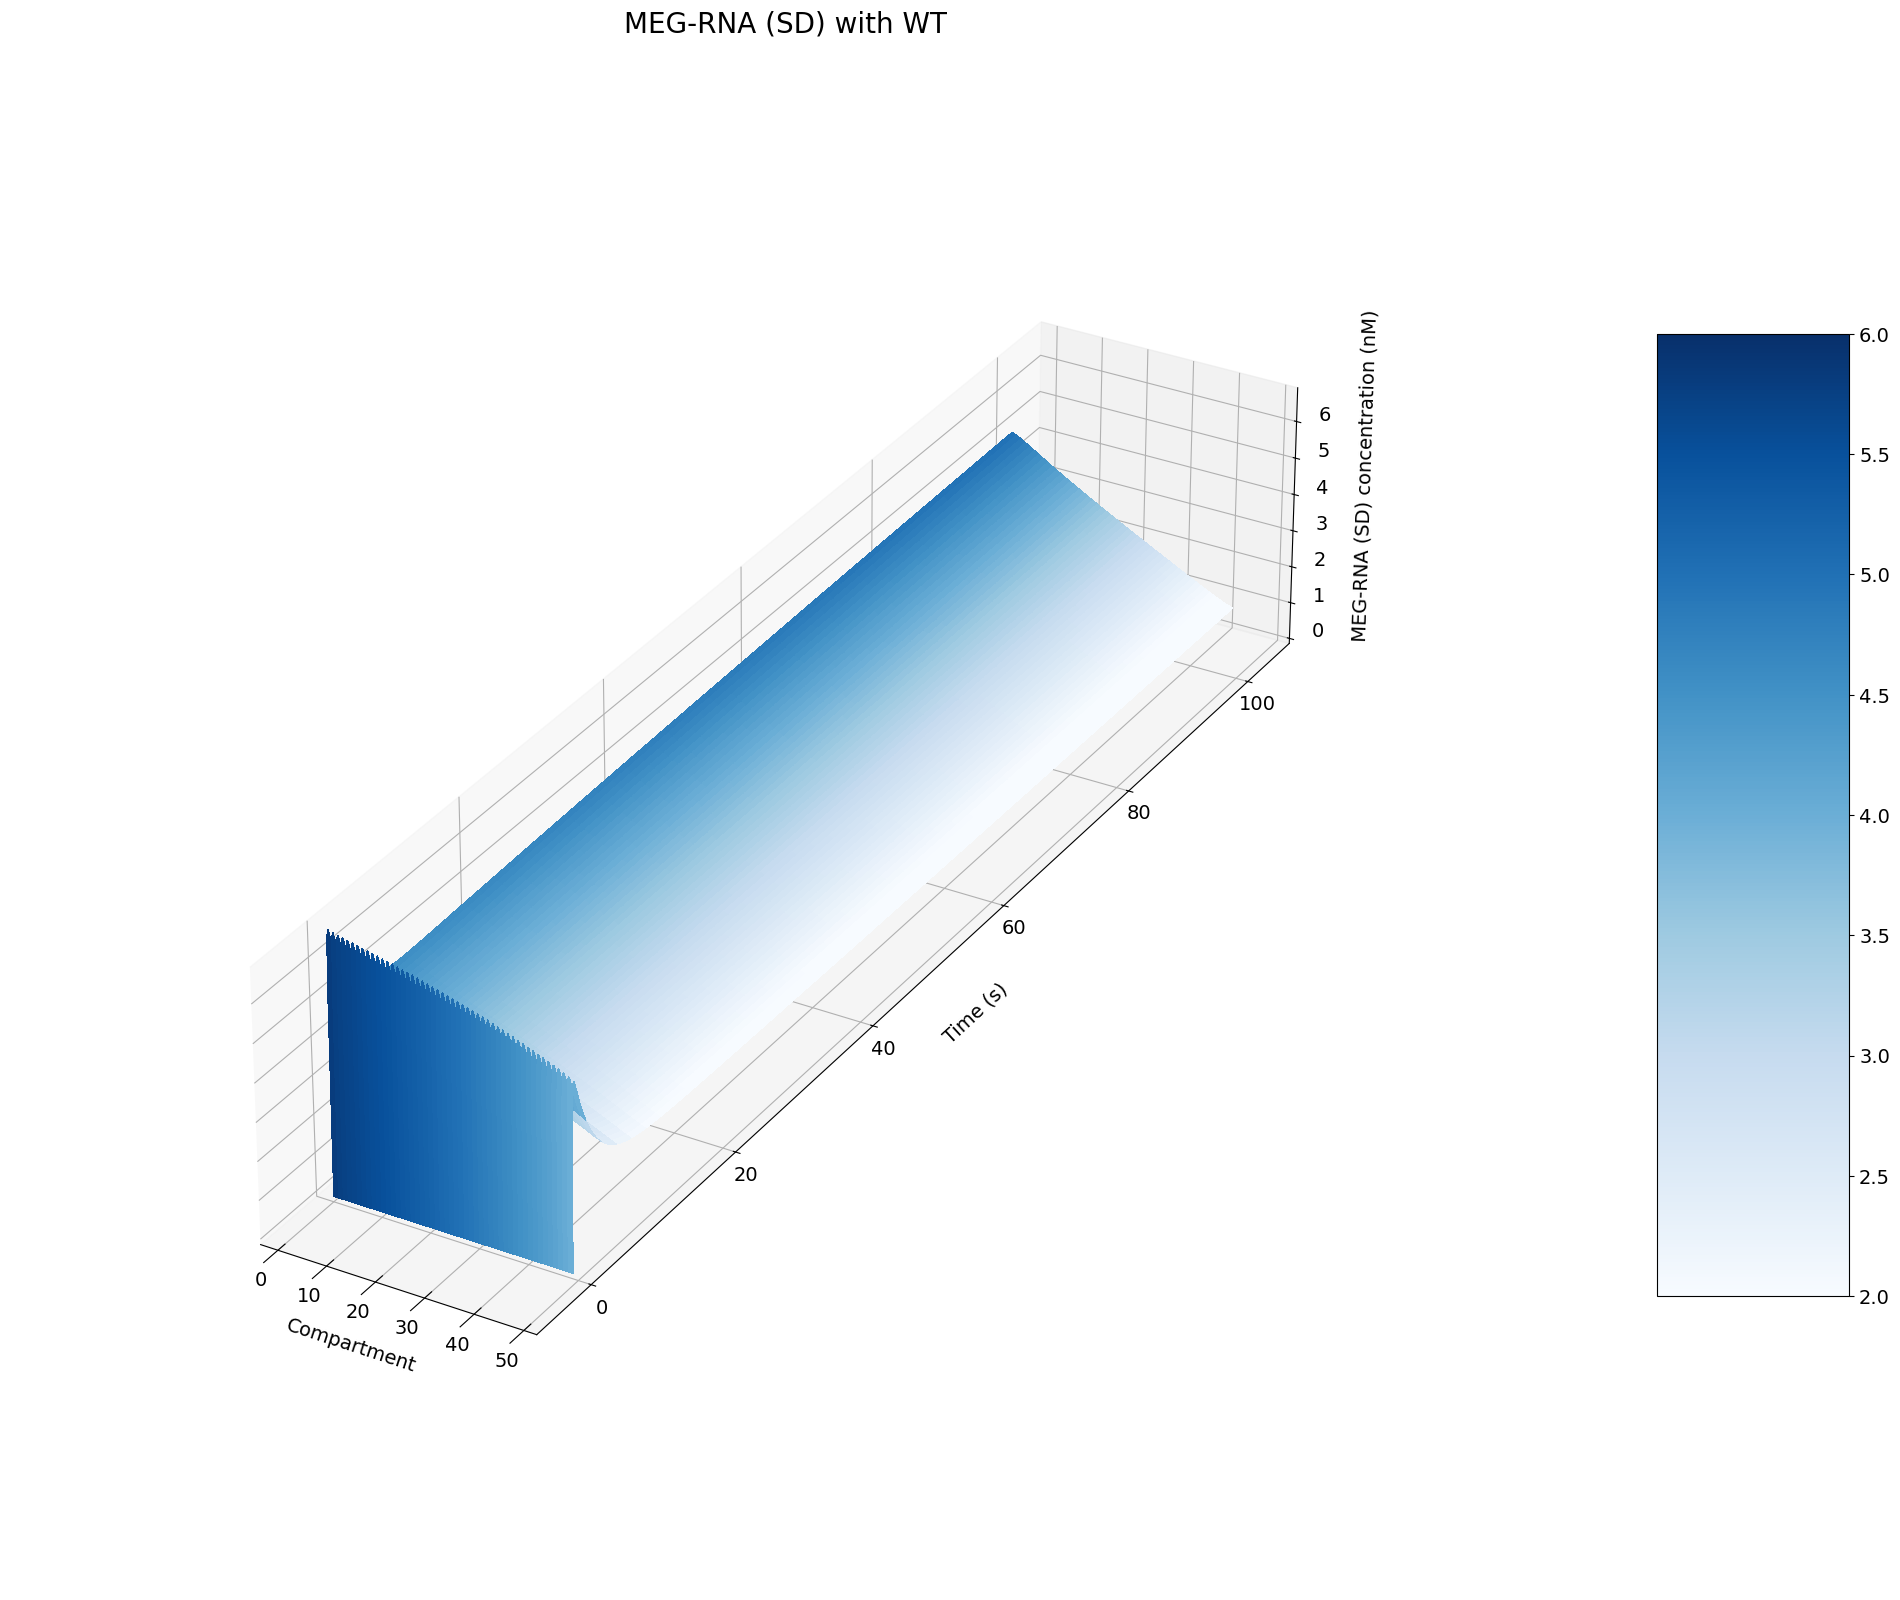

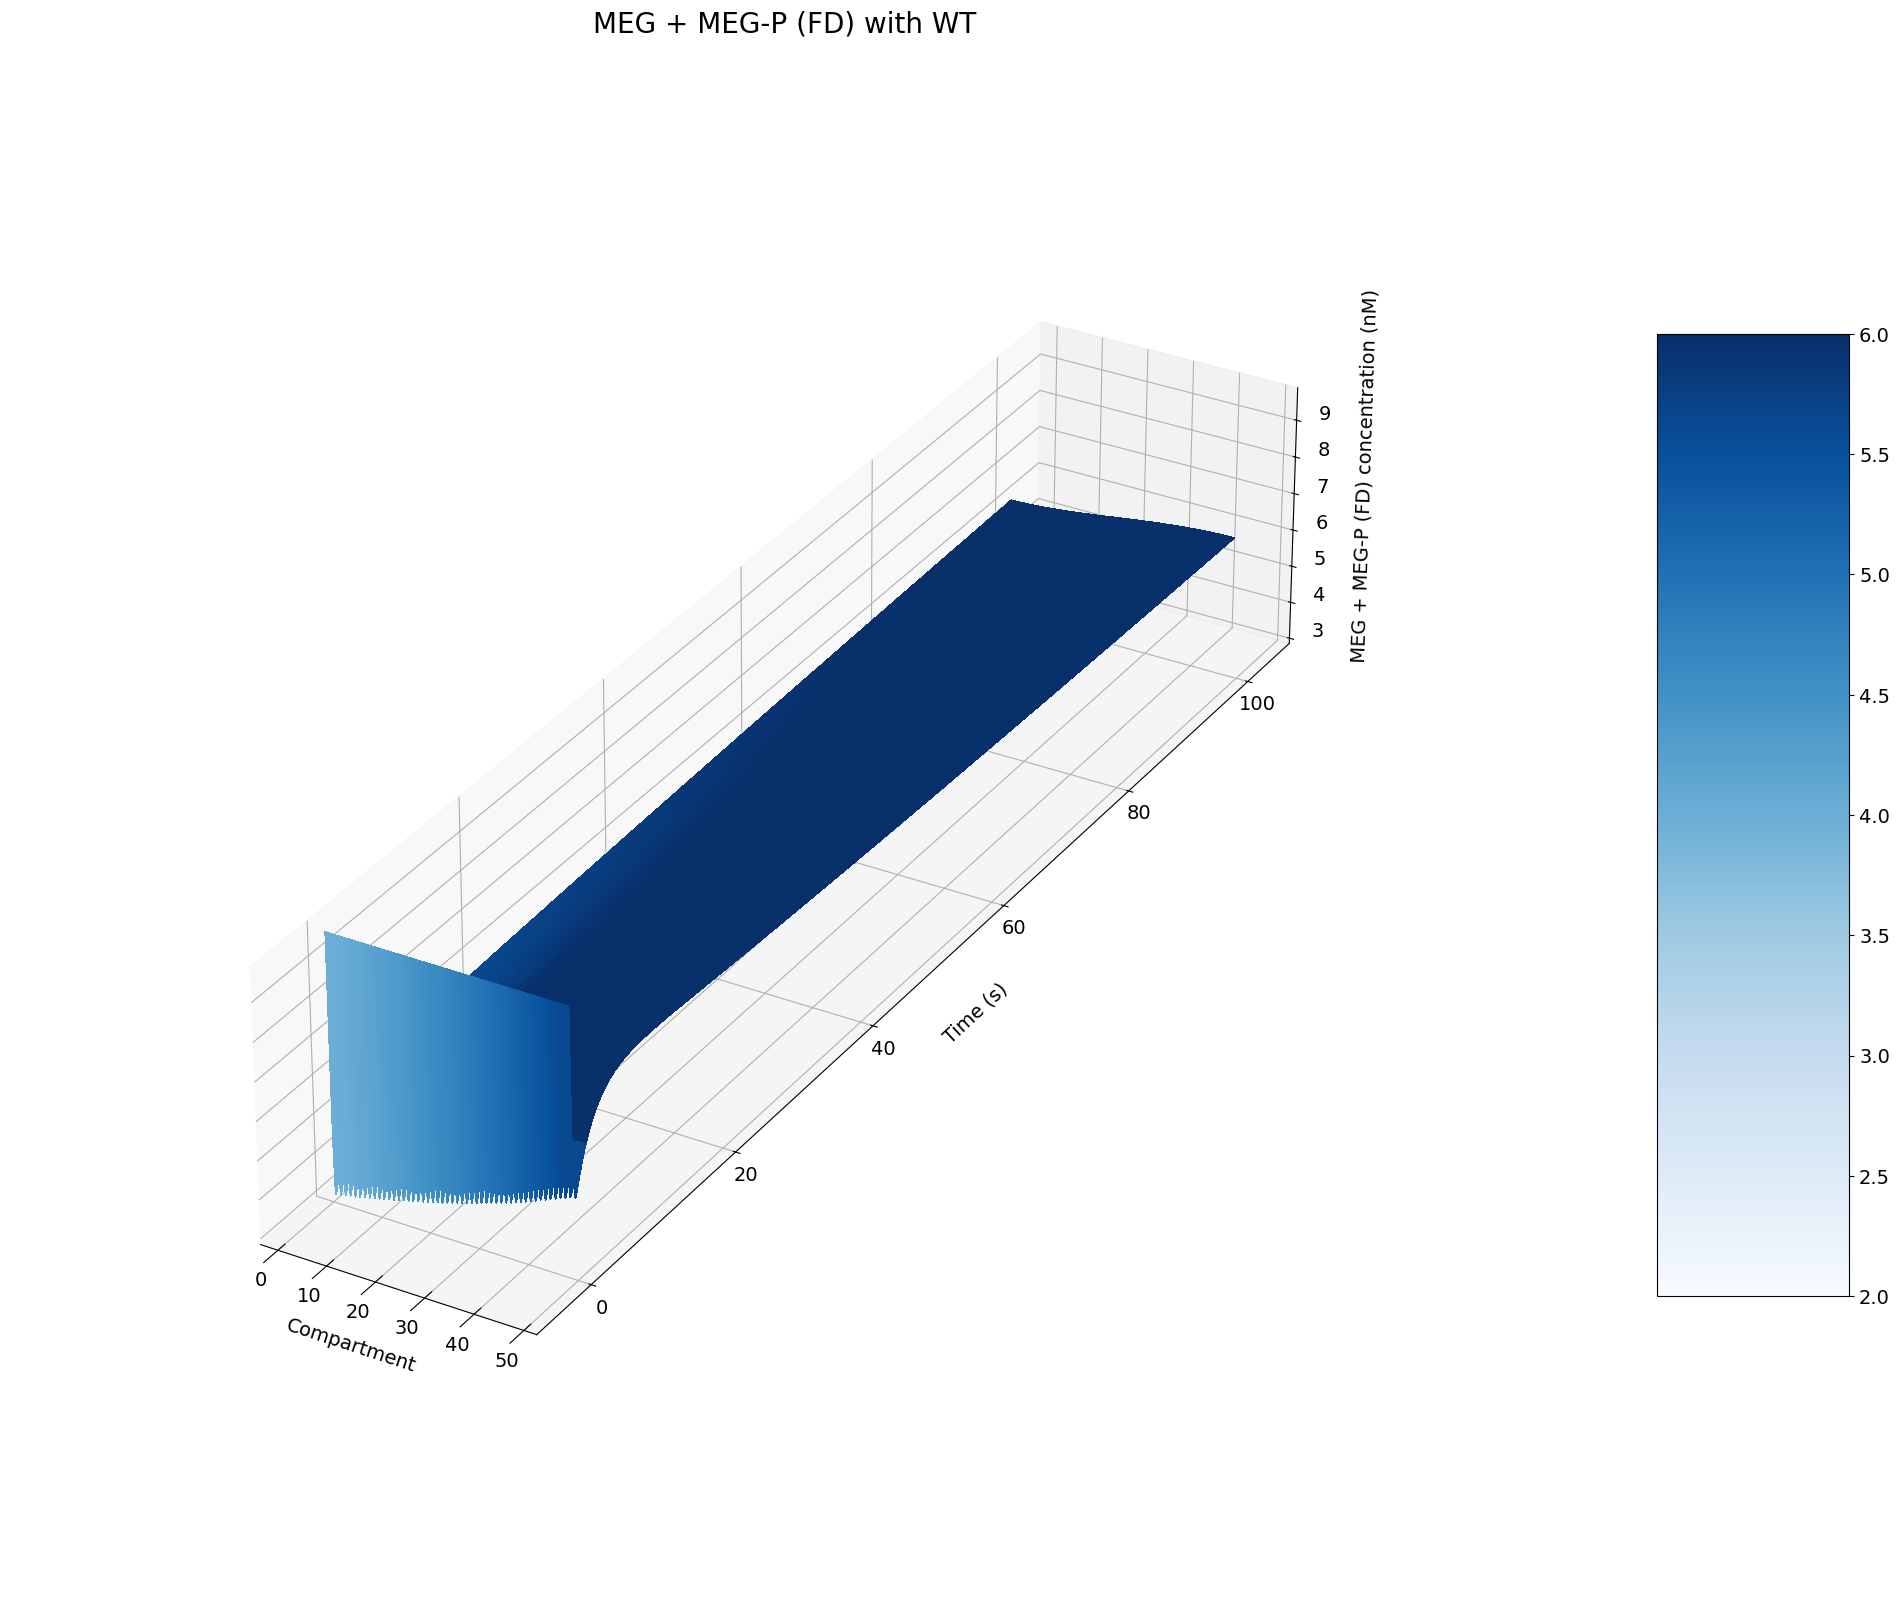

In [6]:
# 3d plot
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# Total MEG
x = np.arange(0,50,1)
y = t
x,y = np.meshgrid(x, y)

fig1 = plt.figure()
fig1.set_figheight(25)
fig1.set_figwidth(25)
ax = fig1.add_subplot(111, projection='3d')

Total_MEG = final_WT_sol[:,range(3*N,4*N)]+final_WT_sol[:,range(N,2*N)]+final_WT_sol[:,range(0,N)]

label_font_size = 14
title_font_size = 20 
tick_font_size = 14

ax.set_box_aspect((1, 5, 1))
surf = ax.plot_surface(x, y, Total_MEG, cmap='Blues',
                       linewidth=0, antialiased=False, vmin=4, vmax=12)
ax.tick_params(axis='x', labelsize=tick_font_size)
ax.tick_params(axis='y', labelsize=tick_font_size,pad=15)
ax.tick_params(axis='z', labelsize=tick_font_size,pad=10)

ax.set_xlabel('Compartment', fontsize=label_font_size, labelpad=10)
ax.set_ylabel('Time (s)', fontsize=label_font_size, labelpad=60)
ax.set_zlabel('Total MEG concentration (nM)', fontsize=label_font_size, labelpad=25)
ax.set_title("Total MEG with WT", fontsize=title_font_size)

cbar=fig1.colorbar(surf, shrink=0.5, aspect=5)
cbar.ax.tick_params(labelsize=label_font_size)

plt.savefig("3d_Total_MEG_WT.pdf")
plt.show()

# SD MEG
x = np.arange(0,50,1)
y = t[:1000]
x,y = np.meshgrid(x, y)

fig2 = plt.figure()
fig2.set_figheight(25)
fig2.set_figwidth(25)
ax = fig2.add_subplot(111, projection='3d')

SD_MEG = final_WT_sol[:1000,range(3*N,4*N)]

ax.set_box_aspect((1, 5, 1))

surf = ax.plot_surface(x, y, SD_MEG, cmap='Blues',
                       linewidth=0, antialiased=False, vmin=2, vmax=6)
ax.tick_params(axis='x', labelsize=tick_font_size)
ax.tick_params(axis='y', labelsize=tick_font_size,pad=15)
ax.tick_params(axis='z', labelsize=tick_font_size,pad=10)

ax.set_xlabel('Compartment', fontsize=label_font_size, labelpad=10)
ax.set_ylabel('Time (s)', fontsize=label_font_size, labelpad=60)
ax.set_zlabel('MEG-RNA (SD) concentration (nM)', fontsize=label_font_size, labelpad=25)
ax.set_title("MEG-RNA (SD) with WT", fontsize=title_font_size)
cbar=fig2.colorbar(surf, shrink=0.5, aspect=5)
cbar.ax.tick_params(labelsize=label_font_size)

plt.savefig("3d_MEG_RNA_SD_WT.pdf")
plt.show()

# SD MEG
x = np.arange(0,50,1)
y = t[:1000]
x,y = np.meshgrid(x, y)

fig2 = plt.figure()
fig2.set_figheight(25)
fig2.set_figwidth(25)
ax = fig2.add_subplot(111, projection='3d')

FD_MEG = final_WT_sol[:1000,range(0,N)]+final_WT_sol[:1000,range(N,2*N)]

ax.set_box_aspect((1, 5, 1))

surf = ax.plot_surface(x, y, FD_MEG, cmap='Blues',
                       linewidth=0, antialiased=False, vmin=2, vmax=6)
ax.tick_params(axis='x', labelsize=tick_font_size)
ax.tick_params(axis='y', labelsize=tick_font_size,pad=15)
ax.tick_params(axis='z', labelsize=tick_font_size,pad=10)

ax.set_xlabel('Compartment', fontsize=label_font_size, labelpad=10)
ax.set_ylabel('Time (s)', fontsize=label_font_size, labelpad=60)
ax.set_zlabel('MEG + MEG-P (FD) concentration (nM)', fontsize=label_font_size, labelpad=25)
ax.set_title("MEG + MEG-P (FD) with WT", fontsize=title_font_size)
cbar=fig2.colorbar(surf, shrink=0.5, aspect=5)
cbar.ax.tick_params(labelsize=label_font_size)

plt.savefig("3d_MEG_MEG_P_FD_WT.pdf")
plt.show()